# **GOVERNMENT PREPARDNESS ANALYSIS**

## Quick Overview

This notebook investigates how governments have been prepared for climate disasters and the human rights impacts of their response. Using EM-DAT and WGI data (2000–2023), it classifies government preparedness, measures severity outcomes, and explores geographic patterns.

A detailed methodology and full findings summary is provided at the end.

**Research Question:**

"How effectively do governments protect fundamental human rights in climate disaster-prone regions, and how can data science models assess and improve state preparedness?"




### Linking Disaster Outcomes to Human Rights

To align this analysis more closely with the overarching research question, disaster severity indicators are interpreted as proxies for violation of fundamental human rights.

| Severity Outcome | Corresponding Human Right |
|------------------|---------------------------|
| Deaths           | Right to Life             |
| Homelessness     | Right to Shelter          |
| Injuries         | Right to Health           |
| Affected Persons | Right to Aid, Health, and Shelter |

These connections help position severity outcomes within a human rights framework and establish a foundation for the Human Rights Protection Analysis that will follow this phase.


## **Importing Libraries for Data Analysis and Visualization**


In [ ]:
# Importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import kruskal
!pip install scikit-posthocs
import scikit_posthocs as sp
import geopandas as gpd
# !pip install xgboost
import xgboost as xgb
!pip install prophet
from prophet import Prophet

**Description:**

This code block imports the essential libraries used throughout the analysis. **pandas** and **numpy** are used for data manipulation and numerical operations. **matplotlib.pyplot**, **seaborn**, and **plotly.express** support both static and interactive data visualizations. **KMeans** from **scikit-learn** enables clustering, while **StandardScaler** standardizes features to ensure comparability across different scales.

**Connection to Research Question:**

The imported libraries provide the computational and analytical tools necessary to examine how governments respond to climate disasters and protect fundamental human rights. These tools enable the development of models to assess state preparedness and visualize patterns across different regions, aligning directly with the thesis objective of using data science to evaluate and improve governmental readiness in disaster-prone areas.

## **Loading and Previewing the Combined Disaster-Governance-Human Rights Dataset**

In [ ]:
# Loading Dataset
df = pd.read_csv("emdat_wgi_rights.csv")

# Viewing all columns
pd.set_option('display.max_columns', None)

df.head()

,ISO,Country,Year,Region,Subregion,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Num_Disasters,Total_Deaths,Total_Injured,Total_Affected,Total_Homeless,Combined_Affected,Total_Damage_USD,Num_OFDA_BHA_Response,Num_Appeals,Num_Declarations,Avg_Magnitude,Common_Magnitude_Scale,Gov_Effectiveness_Estimate,Rights_Violation_Risk,Rights_Risk_Score,Gov_Effectiveness_Imputed
0,AFG,Afghanistan,2000,Asia,Southern Asia,Natural,Climatological,Drought,Drought,1,37,0.0,2580000.0,0.0,2580000.0,50000.0,0,1,0,NaN,Km2,-2.173946,High,3.0,0
1,AFG,Afghanistan,2001,Asia,Southern Asia,Natural,Geophysical,Earthquake,Ground movement,1,4,20.0,0.0,250.0,270.0,0.0,0,0,0,5.0,Moment Magnitude,-1.479362,High,3.0,0
2,AFG,Afghanistan,2002,Asia,Southern Asia,Natural,Geophysical,Earthquake,Ground movement,3,1200,1391.0,89500.0,10000.0,100891.0,0.0,1,0,0,6.1,Moment Magnitude,-1.587687,High,3.0,0
3,AFG,Afghanistan,2002,Asia,Southern Asia,Natural,Hydrological,Flood,Flood (General),2,35,0.0,120.0,0.0,120.0,0.0,0,0,0,NaN,Km2,-1.587687,High,3.0,0
4,AFG,Afghanistan,2002,Asia,Southern Asia,Natural,Hydrological,Flood,Riverine flood,2,46,0.0,5425.0,0.0,5425.0,0.0,0,0,0,2410.0,Km2,-1.587687,High,3.0,0


**Description:**

This code loads the core dataset used for the thesis anaysis. The CSV file, "emdat_wgi_rights.csv", contains data from multiple sources - including climate-related disasters (EM-DAT), governance indicators (WGI), and human rights signals.


**Connection to Research Question:**

This dataset serves as the empirical foundation for analyzing the intersection of climate disaster impacts, governance quality, and human rights protection. By integrating information on disaster outcomes, government responses, and rights-related indicators, this analysis aims to assess how effectively states safeguard fundamental rights under climate-related stress. This dataset enables the development of data-driven models to classify and predict preparedness levels across countries, directly addressing the thesis research question.

## **Log-Transformation of Count-Based Disaster Variables**

In [ ]:
# List of all variables to log-transform
log_vars = [
    'Num_Disasters',
    'Total_Deaths',
    'Total_Injured',
    'Total_Affected',
    'Total_Homeless',
    'Combined_Affected',
    'Total_Damage_USD',
    'Num_OFDA_BHA_Response',
    'Num_Appeals',
    'Num_Declarations'
]

# Apply log1p (log(1 + x)) to safely handle zeroes
for col in log_vars:
    df[col] = df[col].apply(lambda x: np.log1p(x))

# Confirmation message
print("✔️ Log transformation applied to these columns:")
print(log_vars)

✔️ Log transformation applied to these columns:
['Num_Disasters', 'Total_Deaths', 'Total_Injured', 'Total_Affected', 'Total_Homeless', 'Combined_Affected', 'Total_Damage_USD', 'Num_OFDA_BHA_Response', 'Num_Appeals', 'Num_Declarations']


**Description:**

This section applies a natural **logarithm transformation** to **key count-based variables** that represent the severity of disaster events and the scale of government responses—such as **total deaths, injuries, affected populations, and damage estimates**. Log-transforming these skewed variables ensures that extremely high values (e.g., from large-scale disasters) do not **disproportionately influence analysis**. It also enhances **interpretability**, as changes on the log scale correspond to multiplicative differences (e.g., doubling or halving of values). This transformation makes the data more suitable for **modeling, visualization, and cross-country comparison**, especially when dealing with distributions that span several orders of magnitude.


**Connection to Research Question:**

The log-transformation directly contributes to the thesis goal of **assessing government preparedness** by ensuring that disaster severity metrics are evaluated on a more **normalized and comparable scale**. Without this step, extreme disaster events could distort average preparedness levels or mask patterns in smaller, more frequent events. By log-transforming the data, the analysis captures proportional shifts in disaster impact—supporting fairer evaluations of how effectively governments manage crises and protect human rights across diverse contexts and time periods.

##**Descriptive Statistics of Disaster Severity Indicators**

In [ ]:
# Summary Statistics
summary_table = df[['Total_Deaths', 'Total_Injured', 'Total_Homeless', 'Total_Affected']].describe()
summary_table

,Total_Deaths,Total_Injured,Total_Homeless,Total_Affected
count,4342.000000,4342.000000,4342.000000,4342.000000
mean,2.146550,1.323228,1.455002,7.722504
std,2.033551,2.267805,3.245587,5.016320
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,4.615121
50%,1.945910,0.000000,0.000000,8.764907
75%,3.496508,2.397895,0.000000,11.451316
max,12.313001,12.816960,15.424949,19.614603


In [ ]:
# Export as CSV
summary_table.to_csv('summary_statistics.csv')

**Description:**

This code computes summary statistics for key disaster severity indicators — **total deaths, total injured, total homeless, and total affected** — after applying a natural log transformation. Log-scaling reduces the influence of extreme values and allows for easier comparison across events by emphasizing proportional rather than absolute differences. This helps in understanding the distribution and scale of disaster impacts more clearly, especially when values vary across several orders of magnitude.

**Connection to Research Question:**

Analyzing the central tendencies and dispersion of log-transformed disaster impact variables provides refined context for evaluating state preparedness. By compressing skewed distributions, the log transformation highlights relative differences across countries and events, facilitating more interpretable comparisons. These indicators serve as the foundation for classifying countries by preparedness and assessing how well fundamental human rights — such as **the right to life, shelter, and aid** — are protected during disaster conditions. This directly supports the thesis aim of using empirical evidence to assess government effectiveness in safeguarding rights under climate-related crises.


##**Visualizing the distribution of Disaster Severity Indicators (Log Scale)**

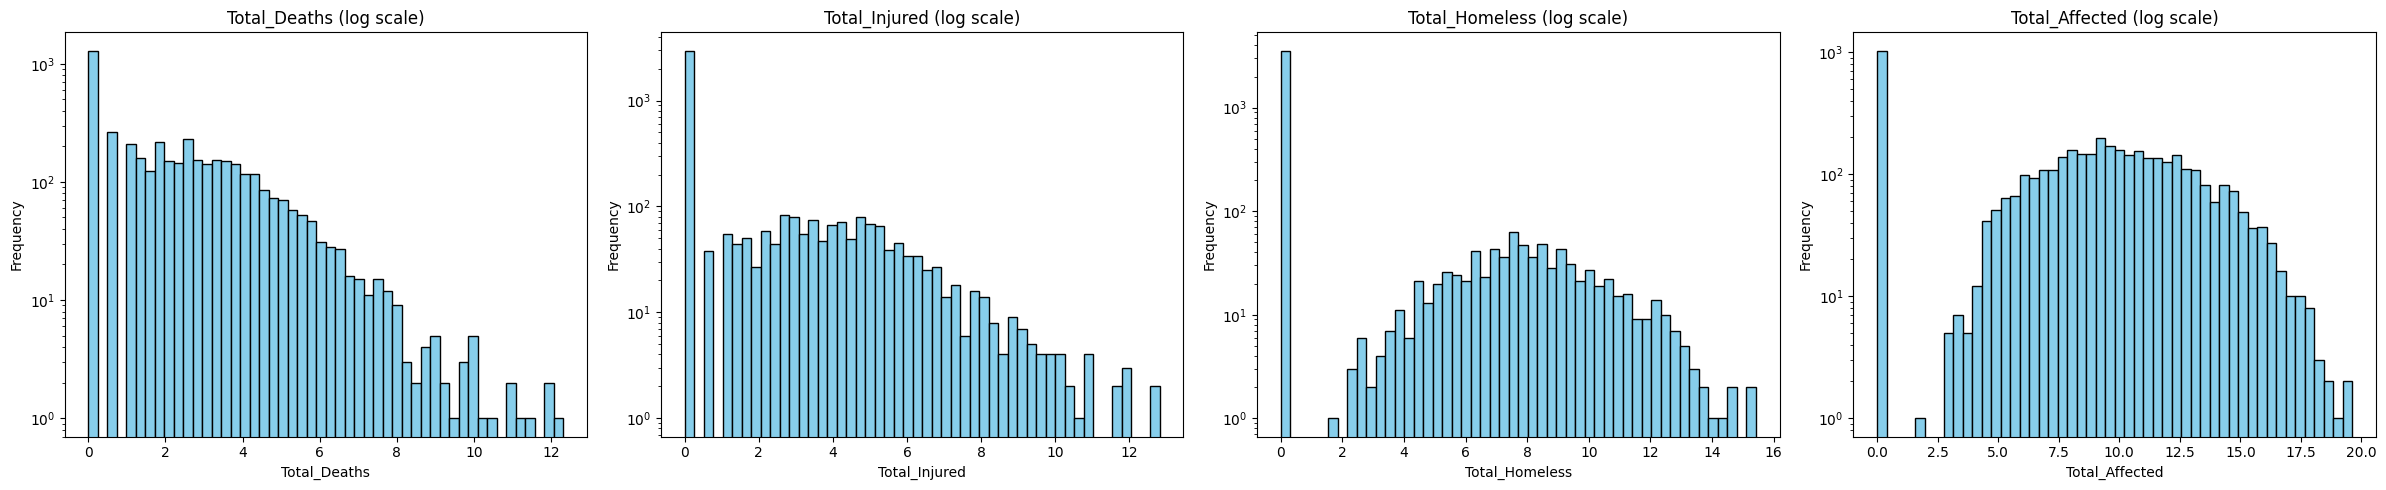

In [ ]:
# Setting up subplots
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

# Ploting each severity indicator
for i, col in enumerate(['Total_Deaths', 'Total_Injured', 'Total_Homeless', 'Total_Affected']):
    axs[i].hist(df[col].dropna(), bins=50, log=True, color='skyblue', edgecolor='black')
    axs[i].set_title(f"{col} (log scale)")
    axs[i].set_xlabel(col)
    axs[i].set_ylabel("Frequency")

plt.tight_layout()

# Save the figure
plt.savefig("severity_distributions_logscale.png", dpi=300)

plt.show()

**Description:**

This code generates histograms for the four main disaster severity variables: **total deaths, total injured, total homeless, and total affected**. A logarithmic transformation (log1p) has been applied to each variable prior to plotting. This transformation reduces skewness from extreme values, enabling clearer visualization of the underlying distribution across both low- and high-impact disaster events.

**Interpretation of Results:**

The severity indicators display clear long-tailed distributions, with most disaster events resulting in relatively limited human impact and a smaller subset producing disproportionately high consequences. Using a logarithmic scale allows these patterns to be interpreted in terms of proportional change—such as doublings or halvings—rather than absolute differences. This provides a more nuanced understanding of disaster severity, where small numeric increases can signal major shifts in human impact. The log-transformed distributions offer a clearer view of variability across events, highlighting both widespread low-severity crises and rarer high-impact disasters that are most likely to test state preparedness and human rights protections.

**Connection to Research Question:**

By applying a log scale to core severity indicators—**deaths, injuries, homelessness, and total affected**—this section advances the thesis objective of evaluating state preparedness and rights protection during disasters. The transformation enables proportional comparisons across countries and events, highlighting relative risk more clearly than raw counts. This supports more robust classification of preparedness and strengthens the foundation for using data science to model how well states safeguard fundamental human rights under climate stress.

##**Classifying Government Preparedness Using Disaster Severity and Population Impact**

In [ ]:
# Classification function
def classify_preparedness(row):
    if (
        row['Total_Deaths'] > 7 or   # ~1,000 deaths
        row['Total_Homeless'] > 11 or  # ~100,000 homeless
        row['Total_Injured'] > 9.5 or  # ~13,000 injured
        row['Total_Affected'] > 13     # ~400,000 affected
    ):
        return "Not Prepared"
    elif (
        row['Total_Deaths'] > 4 or   # ~50 deaths
        row['Total_Homeless'] > 8 or   # ~3,000 homeless
        row['Total_Injured'] > 7 or   # ~1,000 injured
        row['Total_Affected'] > 10    # ~20,000 affected
    ):
        return "Somewhat Prepared"
    else:
        return "Prepared"

# Apply classification function to each row in the dataset
df['Preparedness_Level'] = df.apply(classify_preparedness, axis=1)

# Count how many events fall into each preparedness level
prep_counts = df['Preparedness_Level'].value_counts(normalize=True).reset_index()
prep_counts.columns = ['Preparedness_Level', 'Percent']

# Calculate percentage share of each preparedness level
prep_counts['Percent'] = round(prep_counts['Percent'] * 100, 2)

# Display the result
prep_counts

,Preparedness_Level,Percent
0,Prepared,52.07
1,Somewhat Prepared,32.15
2,Not Prepared,15.78


In [ ]:
prep_counts.to_csv("preparedness_classification_summary.csv", index=False)

**Description:**

This section implements a rule-based classification system to assign each disaster event a preparedness level based on four log-transformed severity metrics: **total deaths, total injured, total homeless, and total affected**. By using logarithmic thresholds, the classification method accounts for the exponential nature of disaster impacts, ensuring that differences in scale—such as thousands versus hundreds of thousands affected—are meaningfully reflected. Events are labeled as **“Prepared,” “Somewhat Prepared,” or “Not Prepared”** based on whether their severity indicators exceed predefined log-based cutoffs. The output provides a categorical summary of government performance in disaster response across a wide range of scenarios.

**Interpretation of Results:**

The classification results show that **52.07%** of disaster events fall under “Prepared,” while **32.15%** are labeled “Somewhat Prepared,” and **15.78%** as “Not Prepared.” These proportions result from a classification scheme that leverages log-scaled thresholds to detect meaningful differences in disaster impact. The use of logarithmic values ensures that events with exponential increases in severity—such as sharp spikes in deaths or displacement—are properly emphasized, while smaller events are proportionally evaluated. The resulting distribution reveals that while most events may not cross extreme severity thresholds, a notable portion still presents significant challenges to government preparedness.

**Connection to Research Question:**

This preparedness classification framework directly supports the thesis objective of **evaluating how effectively governments protect fundamental human rights during climate-related disasters**. By applying log-based thresholds to multiple dimensions of disaster severity—including **mortality, injury, displacement, and overall population impact**—the model captures structural vulnerabilities that may not be apparent through raw values alone. This enables a more realistic, scalable, and policy-relevant assessment of whether governments are equipped to uphold rights such as life, shelter, and access to aid during large-scale emergencies.

##**Summarizing Preparedness Levels by Country**

In [ ]:
# Group the dataset by Country and Preparedness_Level, and count the number of events in each combination
country_preparedness = df.groupby(['Country', 'Preparedness_Level']) \
                         .size() \
                         .unstack(fill_value=0) \
                         .reset_index()

# Preview the top rows
country_preparedness.head(20)

Preparedness_Level,Country,Not Prepared,Prepared,Somewhat Prepared
0,Afghanistan,8,17,26
1,Albania,0,11,5
2,Algeria,1,22,8
3,American Samoa,0,3,1
4,Angola,4,10,16
5,Anguilla,0,1,0
6,Antigua and Barbuda,0,2,1
7,Argentina,0,21,16
8,Armenia,0,5,1
9,Australia,0,44,8


In [ ]:
# Export to CSV
country_preparedness.to_csv("country_by_preparedness_level.csv", index=False)

**Description:**

This section generates a country-level summary of disaster preparedness classifications using log-transformed severity thresholds. The dataset is grouped by **Country** and **Preparedness_Level**, and the number of disaster events falling into each preparedness category is counted. The result is a wide-format DataFrame where each row represents a country, and the columns show the frequency of events classified as **“Prepared,” “Somewhat Prepared,” or “Not Prepared.”** The use of logarithmic thresholds ensures comparability across vastly different event scales and highlights proportionate differences in disaster response outcomes.

**Interpretation of Results:**

The resulting table displays the distribution of disaster preparedness levels across countries based on log-scaled thresholds. For example, Afghanistan recorded 8 events categorized as **“Not Prepared,”** 17 as **“Prepared,”** and 26 as **“Somewhat Prepared.”** These figures reflect a classification scheme that accounts for exponential differences in severity — where each doubling or halving in deaths, injuries, or displacement is meaningfully reflected. The output supports the identification of governments with consistent response weaknesses or strengths, and it highlights countries that frequently fall into lower preparedness categories, which may suggest systemic vulnerabilities or chronic gaps in disaster governance.

**Connection to Research Question:**

This country-level analysis contributes directly to the research question by revealing **how consistently and effectively governments protect human rights under climate-related disaster conditions**. The log-scaled thresholds capture differences not just in absolute numbers, but in proportional impact — making the analysis more sensitive to cases where smaller states may face disproportionate burdens. Countries with frequent “Not Prepared” classifications may face systemic barriers to protecting life, shelter, and access to aid. This overview strengthens the thesis’s broader argument: that data science models can help uncover and address preparedness disparities to better safeguard human rights in disaster-prone areas.


##**Previewing Disaster Events with Preparedness Classifications**

In [ ]:
df[['Country', 'Year', 'Disaster Type', 'Preparedness_Level']].head(10)

,Country,Year,Disaster Type,Preparedness_Level
0,Afghanistan,2000,Drought,Not Prepared
1,Afghanistan,2001,Earthquake,Prepared
2,Afghanistan,2002,Earthquake,Not Prepared
3,Afghanistan,2002,Flood,Prepared
4,Afghanistan,2002,Flood,Prepared
5,Afghanistan,2003,Earthquake,Prepared
6,Afghanistan,2003,Flood,Somewhat Prepared
7,Afghanistan,2003,Flood,Somewhat Prepared
8,Afghanistan,2004,Earthquake,Prepared
9,Afghanistan,2004,Flood,Prepared


In [ ]:
df[df['Country'] == 'Afghanistan']['Year'].nunique()

24

In [ ]:
df[df['Country'] == 'Afghanistan']['Year'].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023])

**Description:**

This command displays a sample of 10 disaster events from the dataset, including the **country, year, type of disaster**, and the assigned **preparedness level** based on severity metrics. All events in this preview are from Afghanistan and illustrate how different types of disasters were classified over time based on severity thresholds.

**Interpretation of Results:**

The preview highlights a variety of disaster types — including **earthquakes**, **floods**, and **droughts** — that occurred in **Afghanistan between 2000 and 2004**. Preparedness levels vary across events, with some classified as “Prepared” and others as “Not Prepared” or “Somewhat Prepared.” This suggests that the model captures meaningful variation even within the same country and reflects differences in impact severity across disaster types and years.

**Connection to Research Question:**

Presenting individual disaster events alongside their preparedness classifications helps ground the thesis in real-world cases. It shows how governments may respond differently across disaster types and over time, offering insight into evolving capacities and challenges. This micro-level view complements the aggregate analysis and supports the broader goal of **assessing whether governments consistently protect fundamental rights in the face of diverse and repeated climate-related disasters.**

##**Visualizing Yearly Disaster Preparedness Trends in Afghanistan (2000-2023)**

,Year,Preparedness_Level,Count
0,2000,Not Prepared,1
1,2001,Prepared,1
2,2002,Not Prepared,1
3,2002,Prepared,2
4,2003,Prepared,1
5,2003,Somewhat Prepared,2
6,2004,Prepared,2
7,2005,Prepared,1
8,2005,Somewhat Prepared,1
9,2006,Not Prepared,1


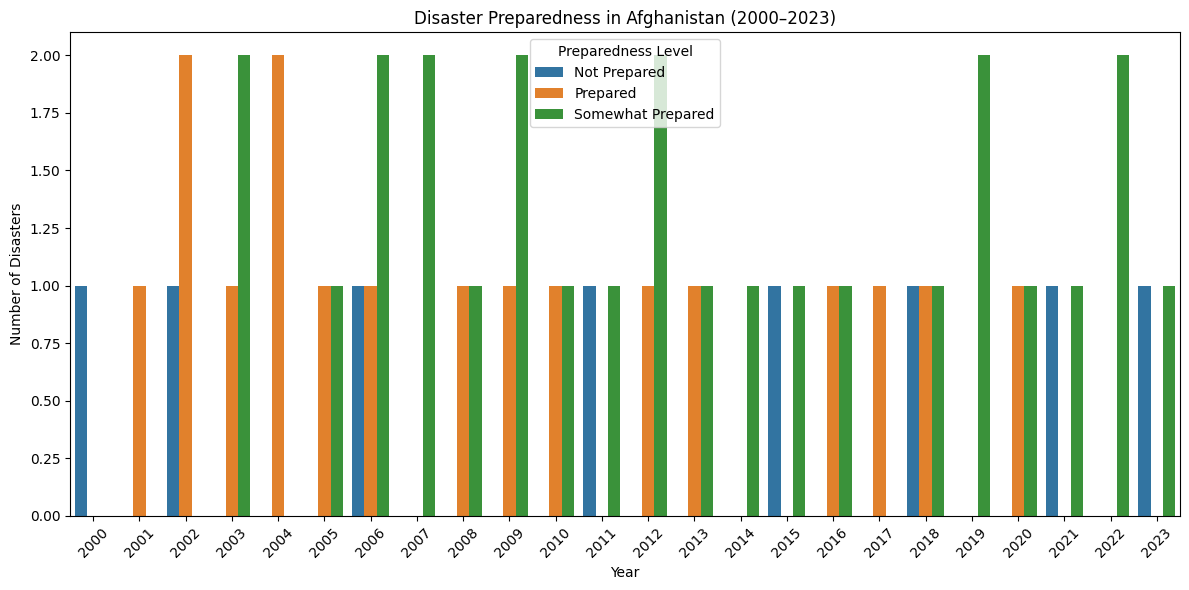

In [ ]:
# Filter for a specific country (Afghanistan in this case)
country = "Afghanistan"
df_country = df[df['Country'] == country]

# Count preparedness levels per year
yearly_prep = df_country.groupby(['Year', 'Preparedness_Level']) \
                        .size().reset_index(name='Count')

# Display the number of disaster events per year and preparedness level
display(yearly_prep.sort_values(by=["Year", "Preparedness_Level"]))

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=yearly_prep, x='Year', y='Count', hue='Preparedness_Level')
plt.title(f"Disaster Preparedness in {country} (2000–2023)")
plt.xlabel("Year")
plt.ylabel("Number of Disasters")
plt.legend(title="Preparedness Level")
plt.xticks(rotation=45)
plt.tight_layout()

# Export figure
plt.savefig(f"{country.lower().replace(' ', '_')}_preparedness_trend.png", dpi=300)

plt.show()

**Description:**

This section visualizes the number of disaster events in Afghanistan per year from 2000 to 2023, grouped by log-based preparedness level thresholds. The data is filtered for Afghanistan and organized by both year and preparedness classification. The resulting bar plot reveals how disaster intensity and government response vary over time, segmented into **“Prepared,” “Somewhat Prepared,”** and **“Not Prepared.”** Using log-scaled indicators allows the visualization to capture both small and large-scale events more proportionally, enhancing the temporal analysis of preparedness.


**Interpretation of Results:**

The plot shows that disaster frequency and preparedness levels **fluctuate significantly over time**. Some years, such as **2002** and **2010**, show a higher number of disasters with mixed preparedness classifications, while other years are marked by fewer but more severe events. This variation suggests that government response capacity is not static — it may improve or decline depending on the nature of the disaster, political context, or resource availability. The presence of all three preparedness categories across multiple years also indicates the model’s sensitivity to event-specific outcomes.

**Connection to Research Question:**

Tracking preparedness levels over time for a single country offers valuable insight into the **temporal dimension of government effectiveness in protecting human rights**. This visualization helps evaluate whether a state consistently demonstrates preparedness or if there are **periods of vulnerability** where fundamental rights are more at risk. Understanding these fluctuations contributes to the thesis goal of using data science to identify both **strengths and gaps in state capacity**, which can inform targeted recommendations for improving rights protection during climate-related disasters.

##**Preparedness Levels by Disaster Subgroup**

In [ ]:
# Create a contingency table showing the number of disaster events per disaster subgroup and preparedness level
df.groupby(['Disaster Subgroup', 'Preparedness_Level']).size().unstack().fillna(0)

Preparedness_Level,Not Prepared,Prepared,Somewhat Prepared
Disaster Subgroup,,,
Climatological,195,150,94
Geophysical,55,223,108
Hydrological,261,1288,845
Meteorological,174,600,349


In [ ]:
# Save the subgroup-preparedness table to a CSV file
subgroup_table = df.groupby(['Disaster Subgroup', 'Preparedness_Level']).size().unstack().fillna(0)
subgroup_table.to_csv("preparedness_by_subgroup.csv")

**Description:**

This table summarizes disaster events by **subgroup**, which classifies disasters based on their broader physical origin — such as **climatological, geophysical, hydrological, or meteorological**. Each row shows how many disasters in that subgroup were categorized into each preparedness level. This breakdown provides insight into how different types of disasters are typically managed, offering a basis for comparing institutional readiness across hazards and identifying patterns in disaster response effectiveness.

**Interpretation of Results:**

- **Climatological disasters** (e.g., droughts, wildfires) have a slightly weaker preparedness profile, with a higher number of “Not Prepared” events (195).

- **Geophysical disasters** (e.g., earthquakes, tsunamis) show relative preparedness with 223 of 386 events marked “Prepared.”

- **Hydrological disasters** (e.g., floods) appear most frequently and show a relatively high share of “Prepared” events (1,288), but still have over 1,106 combined “Not Prepared” and “Somewhat Prepared” events.

- **Meteorological disasters** (e.g., storms, extreme temperatures) are the second most common, and show a wide spread across all three preparedness levels.

These trends suggest that **sudden-onset hazards like earthquakes may be more effectively managed**, while slow-onset or climate-driven events like droughts and extreme weather may challenge state capacities more consistently.


**Connection to Research Question:**

Disaster subgroups help bridge the gap between event-level analysis and broader environmental systems. This breakdown reveals which categories of climate events are **most likely to trigger human rights risks** due to inadequate preparedness. It supports the thesis goal of identifying systemic weaknesses in disaster response and emphasizes the importance of **tailored preparedness strategies** across environmental domains.

##**Preparedness Levels by Disaster Type**

In [ ]:
# Create a contingency table showing the number of disaster events per disaster type and preparedness level
df.groupby(['Disaster Type', 'Preparedness_Level']).size().unstack().fillna(0)

Preparedness_Level,Not Prepared,Prepared,Somewhat Prepared
Disaster Type,,,
Drought,195.0,115.0,81.0
Earthquake,55.0,223.0,108.0
Extreme temperature,41.0,84.0,91.0
Flood,261.0,1288.0,845.0
Storm,133.0,516.0,258.0
Wildfire,0.0,35.0,13.0


In [ ]:
# Create the disaster type vs. preparedness table
type_table = df.groupby(['Disaster Type', 'Preparedness_Level']).size().unstack().fillna(0)

# Save it as a CSV
type_table.to_csv("preparedness_by_disaster_type.csv")

**Description:**

This command summarizes the number of disaster events for each **disaster type**, broken down by **preparedness level**. The result is a contingency table showing how many events of each type were classified as **“Prepared,”** **“Somewhat Prepared,”** or **“Not Prepared.”** This breakdown helps identify which types of disasters tend to be managed more effectively and which are more likely to overwhelm state response capacities.

**Interpretation of Results:**

The table shows clear differences in preparedness across disaster types. For instance:

- **Floods** are the most frequent and have a relatively high number of “Prepared” responses (1,288), but also a notable number of “Not Prepared” (261) and “Somewhat Prepared” (845) cases — highlighting variability.
- **Earthquakes** are also common, with most classified as “Prepared” (223), though 55 are “Not Prepared.”
- **Droughts** show the greatest balance across all three categories, suggesting a mixed record in preparedness.
- **Storms** and **extreme temperatures** also show considerable variation.
- **Wildfires** are rare in the dataset and mostly classified as “Prepared.”

These differences suggest that **some disaster types are consistently harder to manage**, while others may benefit from more established response mechanisms or early warning systems.

**Connection to Research Question:**

By analyzing preparedness by disaster type, this section addresses a key dimension of the thesis: understanding **how the nature of climate hazards influences government capacity to uphold human rights**. Some hazards — like floods — may allow for stronger institutional responses due to their frequency and predictability, while others — like droughts or earthquakes — may expose structural weaknesses. This analysis helps pinpoint where **rights protections are most at risk** depending on the hazard, providing a targeted lens for strengthening preparedness systems.

##**Preparedness Levels by Disaster Subtype**

In [ ]:
# Create a contingency table showing the number of disaster events per disaster subtype and preparedness level
subtype_preparedness = df.groupby(['Disaster Subtype', 'Preparedness_Level']).size().unstack().fillna(0)
subtype_preparedness

Preparedness_Level,Not Prepared,Prepared,Somewhat Prepared
Disaster Subtype,,,
Coastal flood,4.0,16.0,14.0
Drought,195.0,115.0,81.0
Flash flood,41.0,303.0,166.0
Flood (General),79.0,388.0,234.0
Ground movement,46.0,211.0,100.0
Hail,3.0,30.0,9.0
Heat wave,41.0,84.0,91.0
Lightning/Thunderstorms,3.0,95.0,20.0
Riverine flood,137.0,581.0,431.0


In [ ]:
# Export to CSV
subtype_preparedness.to_csv("disaster_subtype_by_preparedness.csv")

**Description:**

This breakdown displays preparedness levels by **disaster subtype**, offering the most granular view. Subtypes include specific hazard forms like **“Flash Flood,” “Tropical Cyclone,” or “Heat Wave.”** This classification allows for detailed comparisons between distinct types of events and how governments respond to each.

**Interpretation of Results:**

- **Riverine floods** and **tropical cyclones** stand out for having many events and relatively high “Prepared” counts (581 and 330 respectively), but still a sizable number of less-prepared cases.
- **Flash floods** show more mixed preparedness, with 166 out of 510 events falling below “Somewhat Prepared.”
- **Droughts** show relatively poor preparedness, with 195 “Not Prepared” cases — the highest among all subtypes.
- Rare subtypes like **sand/dust storms**, **tornadoes**, and **tsunamis** appear less frequently, but still reflect inconsistent readiness.

These results reveal that **even within the same disaster group**, **preparedness varies widely by subtype**, highlighting the importance of hazard-specific response systems.

**Connection to Research Question:**

This level of detail strengthens the ability to assess **which exact types of disasters pose the greatest threat to human rights** due to weak preparedness. It underscores the need for specialized early warning systems, contingency planning, and infrastructure tailored to high-risk subtypes. This contributes directly to the thesis aim of using data science to inform **targeted preparedness improvements** where they are most needed.

##**Regional Patterns in Disaster Preparedness**

In [ ]:
# Regional breakdown of preparedness levels
regional_prep_table = df.groupby(['Region', 'Preparedness_Level']).size().unstack().fillna(0)
regional_prep_table

Preparedness_Level,Not Prepared,Prepared,Somewhat Prepared
Region,,,
Africa,39.0,81.0,85.0
Asia,209.0,161.0,204.0
Central America,3.0,57.0,33.0
Europe,17.0,135.0,14.0
North America,10.0,65.0,27.0
Oceania,0.0,67.0,10.0
South America,27.0,104.0,77.0


In [ ]:
# Create CSV
regional_prep_table.to_csv("regional_preparedness_levels.csv")

**Description:**

This table summarizes the number of disaster events by **region** (e.g., Africa, Americas, Asia, Europe, and Oceania), broken down by preparedness level. **It highlights how states across different world regions perform in managing disasters in terms of death, injury, homelessness, and population affected.**

**Interpretation of Results:**

- **Asia** has the highest overall disaster count, including the most “Not Prepared” events (374) and the largest number of “Somewhat Prepared” events (507), suggesting a high variability in response quality.
- **Africa** also shows a high number of events with weaker preparedness classifications — 187 “Not Prepared” and 399 “Somewhat Prepared.”
- **The Americas** and **Europe** have relatively fewer “Not Prepared” events and a stronger concentration in the “Prepared” category.
- **Oceania** shows the fewest total events, with a fairly strong preparedness profile.

These results suggest that while disaster frequency varies by region, gaps in preparedness are more common in Africa and Asia, **indicating potential strain on state capacity in high-risk zones.**

**Connection to Research Question:**

This regional analysis directly supports the thesis by revealing **geographic disparities in government preparedness** for climate-related disasters. Regions with more “Not Prepared” events may struggle to uphold human rights protections consistently, especially under conditions of repeated or large-scale hazards. The findings offer direction for **regional targeting of resilience-building and international aid**, aligned with the broader goal of strengthening state capacity to protect fundamental rights.

##**Visualizing Disaster Preparedness by Region (Stacked Bar Chart)**

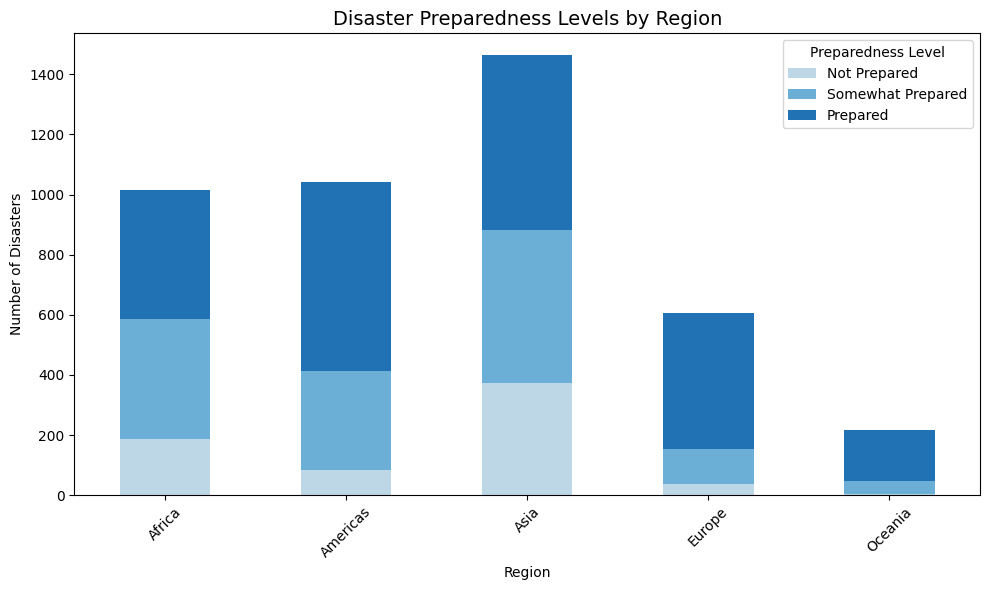

In [ ]:
# Define pastel blue gradient palette
blue_gradient = {
    'Not Prepared': '#bdd7e7',      # light blue
    'Somewhat Prepared': '#6baed6', # medium blue
    'Prepared': '#2171b5'           # deeper blue
}

# Group and prepare data
region_prep = df.groupby(['Region', 'Preparedness_Level']).size().unstack().fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
region_prep[['Not Prepared', 'Somewhat Prepared', 'Prepared']].plot(
    kind='bar',
    stacked=True,
    color=[blue_gradient['Not Prepared'],
           blue_gradient['Somewhat Prepared'],
           blue_gradient['Prepared']],
    ax=ax
)

# Customize
plt.title("Disaster Preparedness Levels by Region", fontsize=14)
plt.xlabel("Region")
plt.ylabel("Number of Disasters")
plt.legend(title="Preparedness Level")
plt.xticks(rotation=45)
plt.tight_layout()

# Save figure
plt.savefig("figure_disaster_preparedness_by_region_blue.png", dpi=300)

plt.show()

**Description:**

This stacked bar chart displays the number of disaster events per **region**, categorized by **preparedness level**. It helps visualize not only the total number of disasters each region experiences, but also the distribution of events classified as “Prepared,” “Somewhat Prepared,” or “Not Prepared.”

**Interpretation of Results:**

The plot highlights striking regional differences. **Asia** and **Africa** experience the highest number of disaster events with a substantial portion falling into the “Not Prepared” or “Somewhat Prepared” categories, suggesting structural challenges in response systems. In contrast, Europe, Oceania, and the Americas show a larger share of “Prepared” events, though even these regions are not without instances of inadequate response.

**Connection to Research Question:**

This visualization helps answer the thesis question by clearly showing **where governments are more or less prepared** to manage disasters that threaten fundamental rights. Regions with large portions of unprepared events likely face greater difficulties in protecting life, shelter, and health during climate crises. This supports the need for **regionally targeted preparedness strategies, international support mechanisms, and deeper investigation into the root causes of regional gaps in disaster governance.**

##**Subregional Patterns in Disaster Preparedness**

In [ ]:
# Subregional breakdown of preparedness levels
subregional_prep_table = df.groupby(['Subregion', 'Preparedness_Level']).size().unstack().fillna(0)
subregional_prep_table

Preparedness_Level,Not Prepared,Prepared,Somewhat Prepared
Subregion,,,
Australia and New Zealand,0.0,67.0,10.0
Central Asia,4.0,53.0,12.0
Eastern Asia,100.0,144.0,103.0
Eastern Europe,7.0,134.0,40.0
Latin America and the Caribbean,76.0,489.0,289.0
Melanesia,4.0,51.0,24.0
Micronesia,0.0,23.0,5.0
Northern Africa,10.0,60.0,32.0
Northern America,7.0,140.0,40.0


In [ ]:
# Create CSV
subregional_prep_table.to_csv("subregional_preparedness_levels.csv")

**Description:**

This table disaggregates disaster preparedness levels by **subregion**, offering a more detailed view than the regional analysis. It captures differences in disaster management across 15+ subregions, including areas like Sub-Saharan Africa, South-Eastern Asia, and Western Europe.

**Interpretation of Results:**

- **Sub-Saharan Africa** shows a very high number of events marked as “Not Prepared” (117) and “Somewhat Prepared” (367), indicating significant challenges in disaster response.
- **South and South-Eastern Asia** also show elevated levels of unpreparedness, despite high disaster frequency.
- **Latin America and the Caribbean** show strong performance, with 489 “Prepared” events out of 854 total.
- **Eastern Asia** and **Northern America** have relatively better distributions, with a majority of events categorized as “Prepared.”

This granularity reveals **within-region variation**, identifying subregions that are both vulnerable and **resilient** depending on their preparedness profiles.

**Connection to Research Question:**

Subregional analysis helps pinpoint **specific geographic areas where human rights protections are at greatest risk** due to weak disaster preparedness. It adds a precision layer to the thesis by moving beyond country or regional aggregates to identify where state response consistently falls short. This supports the case for targeted policy interventions, technical support, or international partnerships to improve resilience in **high-risk subregions**.

##**Visualizing Disaster Preparedness by Subregion (Stacked Bar Chart)**

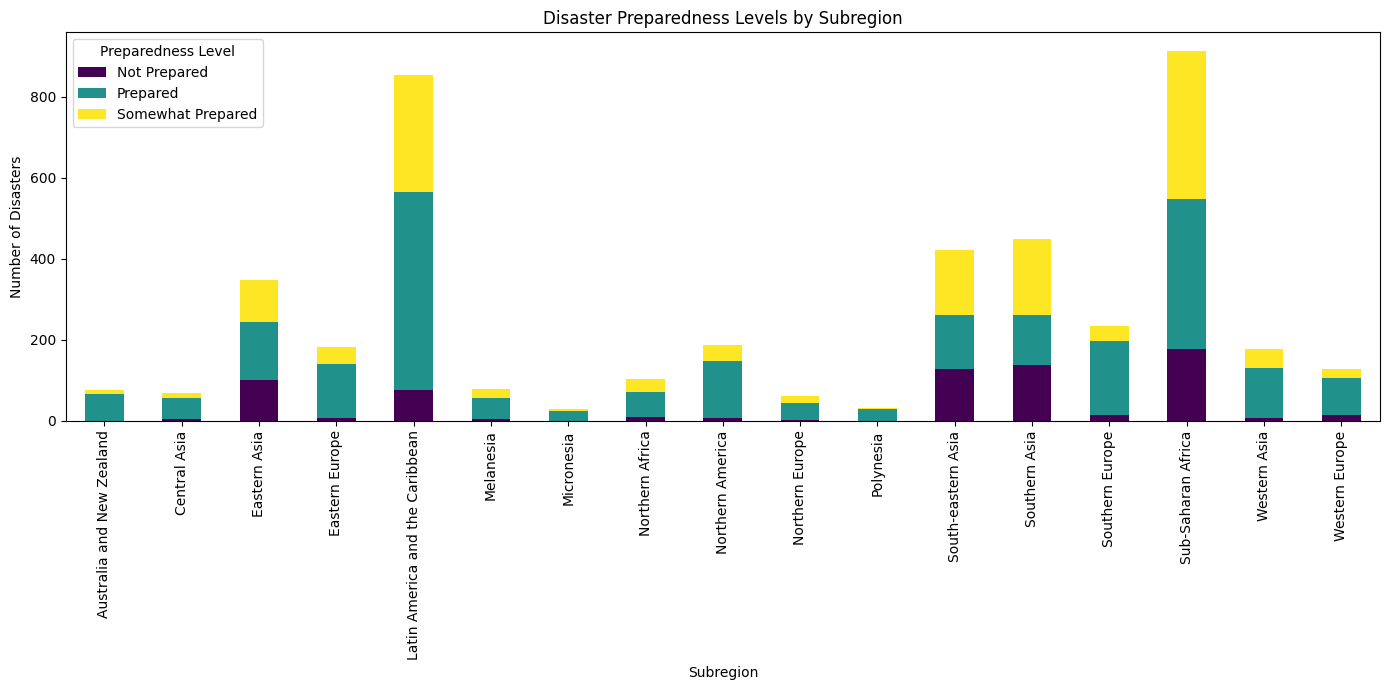

In [ ]:
# Group and prepare data
subregion_prep = df.groupby(['Subregion', 'Preparedness_Level']).size().unstack().fillna(0)

# Plot
subregion_prep.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')
plt.title("Disaster Preparedness Levels by Subregion")
plt.xlabel("Subregion")
plt.ylabel("Number of Disasters")
plt.legend(title="Preparedness Level")
plt.xticks(rotation=90)
plt.tight_layout()

# Save figure
plt.savefig("preparedness_by_subregion.png", dpi=300)
plt.show()

**Description:**

This chart breaks down **disaster preparedness** by **subregion**, offering a more granular view of how different parts of the world perform in terms of managing disaster impacts. Subregions include clusters such as **Sub-Saharan Africa, South-Eastern Asia, and Western Europe**, allowing for closer analysis of patterns within broader geographic zones.


**Interpretation of Results:**

The plot reveals that **Sub-Saharan Africa** has one of the highest total disaster counts and the largest number of events classified as “Not Prepared,” suggesting widespread gaps in disaster response infrastructure. Similarly, **South-Eastern Asia** and **Southern Asia** show elevated proportions of unprepared events despite frequent disasters. In contrast, **Latin America and the Caribbean** demonstrate stronger preparedness performance, with most events classified as “Prepared”. These subregional differences highlight the uneven distribution of institutional capacity and resources to respond effectively to climate hazards.


**Connection to Research Question:**

This subregional analysis enhances the thesis by identifying **precise geographic hotspots** where governments may struggle to uphold human rights during disasters. It enables a more targeted understanding of risk by pinpointing subregions that consistently fall into lower preparedness categories. These insights support the thesis aim of using data science to inform **evidence-based interventions** and policies that strengthen resilience in the world’s most vulnerable areas.

##**Constructing a National Preparedness Index**

In [ ]:
# Count the number of disaster events per preparedness level for each country and reshape into a wide format table
country_prep = df.groupby(['Country', 'Preparedness_Level']).size().unstack(fill_value=0)

# Create a copy to avoid altering the original table
prep_index = country_prep.copy()

# Fill missing columns
for col in ['Prepared', 'Somewhat Prepared', 'Not Prepared']:
    if col not in prep_index.columns:
        prep_index[col] = 0

# Calculate total events per country
prep_index['Total'] = prep_index.sum(axis=1)

# Calculate weighted score (index from 0 to 1)
prep_index['Preparedness_Index'] = (
    (prep_index['Prepared'] * 1.0 + prep_index['Somewhat Prepared'] * 0.5 + prep_index['Not Prepared'] * 0.0)
    / prep_index['Total']
)

# Sort descending by preparedness score
prep_index_sorted = prep_index.sort_values(by='Preparedness_Index', ascending=False)

# Preview
prep_index_sorted[['Prepared', 'Somewhat Prepared', 'Not Prepared', 'Total', 'Preparedness_Index']].head()

Preparedness_Level,Prepared,Somewhat Prepared,Not Prepared,Total,Preparedness_Index
Country,,,,,
Anguilla,1,0,0,1,1.0
Bermuda,1,0,0,1,1.0
Barbados,8,0,0,8,1.0
Cayman Islands,4,0,0,4,1.0
Canary Islands,4,0,0,4,1.0


In [ ]:
# Select and export the relevant columns
prep_index_sorted[['Prepared', 'Somewhat Prepared', 'Not Prepared', 'Total', 'Preparedness_Index']] \
    .to_csv("preparedness_index_by_country.csv")

**Description:**

This code block calculates a **Preparedness Index** for each country by scoring their disaster events based on severity response classification. **“Prepared”** events are scored as 1.0, **“Somewhat Prepared”** as 0.5, and **“Not Prepared”** as 0.0. Each country’s index is computed as the **weighted average** of all events it experienced, allowing for a standardized comparison across countries regardless of total disaster frequency.

**Interpretation of Results:**

The resulting index ranges from 0 (unprepared) to 1 (prepared). Countries like **Anguilla, Bermuda, and Barbados** score a perfect 1.0, meaning that all their recorded disaster events were classified as “Prepared.” While this may reflect strong response systems, it could also be influenced by a **small number of recorded events**, which warrants caution in interpretation. Countries with larger event volumes will show more variation, providing clearer signals of consistent preparedness or vulnerability.

**Connection to Research Question:**

The Preparedness Index provides a **quantitative foundation for evaluating how effectively governments protect fundamental human rights** during climate-related disasters. It translates qualitative labels into a robust metric that enables **ranking, comparison, and visualization** of state performance. **This contributes directly to the thesis goal of using data science to assess government readiness to uphold the rights to life, shelter, and health in disaster-prone regions.**

##**Mapping the Global Preparedness Index (2000-2023)**

In [ ]:
# Reset index to prepare for mapping
prep_index_map = prep_index_sorted.reset_index()

# Create choropleth map
fig = px.choropleth(
    prep_index_map,
    locations="Country",
    locationmode="country names",  # Match to standard country names
    color="Preparedness_Index",
    color_continuous_scale="Viridis",  # or "RdYlGn", "Blues", etc.
    range_color=(0, 1),
    title="Global Preparedness Index (2000–2023)",
    labels={"Preparedness_Index": "Preparedness Score"},
    hover_name="Country",
    hover_data={"Prepared": True, "Somewhat Prepared": True, "Not Prepared": True, "Total": True, "Country": False}
)

fig.update_geos(showframe=False, showcoastlines=True)
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})

fig.show()

**Description:**

This interactive **choropleth map** visualizes the Preparedness Index for each country, calculated based on the classification of disaster events from 2000 to 2023. The map uses a continuous color gradient from dark purple (low preparedness) to yellow (high preparedness), with hover labels displaying each country’s total number of disasters and distribution across preparedness levels.

**Interpretation of Results:**

The map clearly shows regional clustering in disaster preparedness. Countries in **North America**, **Western Europe**, and parts of **Latin America** tend to score higher, reflecting more robust disaster response systems. In contrast, many countries in **Sub-Saharan Africa**, **South Asia**, and **South-East Asia** fall into lower index ranges, indicating consistent challenges in managing disaster impacts. This geographic distribution supports earlier statistical summaries and highlights areas of systemic risk.

**Connection to Research Question:**

The Preparedness Index map directly answers the core thesis question — **how effectively governments protect fundamental human rights in disaster-prone regions**. Countries with low preparedness scores are likely to struggle in upholding **rights to life, shelter, health, and access to aid** during emergencies. The map serves as a compelling and policy-relevant visual tool for:
- Identifying global disparities
- Prioritizing support
- Informing recommendations for targeted disaster governance reforms

**Saving Key Processed Dataframes**

In [ ]:
# Save full disaster-level dataset with Preparedness_Level
df.to_csv("phase1_disaster_data_with_preparedness.csv", index=False)

# Save country-level index summary
prep_index_sorted.to_csv("preparedness_index_by_country.csv")

##**Testing Stricter Thresholds for Preparedness Classification**

In [ ]:
# Current preparedness classification distribution
df['Preparedness_Level'].value_counts(normalize=True).round(3) * 100

,proportion
Preparedness_Level,
Prepared,52.1
Somewhat Prepared,32.2
Not Prepared,15.8


**Description:**

This section evaluates how the classification of government preparedness changes when **stricter standards are applied**.

While the original thresholds defined countries as Prepared, Somewhat Prepared, or Not Prepared using moderate cutoffs, this section explores how classifications shift when governments are held to **higher expectations of effectiveness in disaster governance.**

A function is first defined to allow reclassification using custom thresholds.

In [ ]:
# Define a function to reclassify government preparedness levels based on adjustable thresholds applied to the governance effectiveness score.
def reclassify_preparedness(df, threshold_low=0.33, threshold_high=0.67):
    df_test = df.copy()
    df_test['Preparedness_Level_Alt'] = pd.cut(
        df_test['Gov_Effectiveness_Imputed'],
        bins=[-float('inf'), threshold_low, threshold_high, float('inf')],
        labels=['Not Prepared', 'Somewhat Prepared', 'Prepared']
    )
    return df_test

# It creates a new column 'Preparedness_Level_Alt' with categories: Not Prepared, Somewhat Prepared, and Prepared.

A stricter test scenario is then applied using thresholds of 0.4 and 0.75.


In [ ]:
# Example: stricter thresholds
df_test = reclassify_preparedness(df, threshold_low=0.4, threshold_high=0.75)

# View new distribution
df_test['Preparedness_Level_Alt'].value_counts(normalize=True).round(3) * 100

,proportion
Preparedness_Level_Alt,
Not Prepared,97.5
Prepared,2.5
Somewhat Prepared,0.0


In [ ]:
# Calculate and format new distribution (percentages)
alt_prep_dist = df_test['Preparedness_Level_Alt'].value_counts(normalize=True).round(3) * 100
alt_prep_dist = alt_prep_dist.reset_index()
alt_prep_dist.columns = ['Preparedness_Level', 'Percent']

# Export as CSV
alt_prep_dist.to_csv("alt_preparedness_distribution_strict.csv", index=False)


**Interpretation of Results:**

The original classification used moderate thresholds to determine whether a country was **“Prepared,” “Somewhat Prepared,” or “Not Prepared”**. Under this setup, approximately **52.1%** of disaster events were associated with countries classified as “Prepared,” **32.2%** as “Somewhat Prepared,” and only **15.8%** as “Not Prepared.”

However, when stricter thresholds were applied—requiring higher levels of government effectiveness to qualify as “Prepared”—the classification shifted dramatically. Nearly **97.5%** of events were now associated with countries labeled as “Not Prepared,” while only **2.5%** met the stricter standard of preparedness. This sharp contrast suggests that the original model may have overstated global preparedness levels, classifying countries as “Prepared” despite limited real-world capacity to effectively manage disasters.

This reclassification exposes a potential misalignment between nominal government performance scores and the actual resilience needed to uphold human rights during crises. It raises critical concerns about the adequacy of current benchmarks in identifying countries genuinely capable of protecting populations when disasters strike.

**Connection to Research Question:**

This reclassification experiment directly supports the thesis research question: **“How effectively do governments protect fundamental human rights in climate disaster-prone regions, and how can data science models assess and improve state preparedness?”**

By imposing stricter definitions of what constitutes “Prepared,” the analysis reveals that many governments previously considered effective may, in practice, lack the capacity to guarantee basic protections in disaster contexts. This reinforces the argument that rights-sensitive thresholds are essential for assessing state performance. It also demonstrates how data science methods—particularly those that test classification sensitivity—can expose underlying vulnerabilities and inform more realistic, justice-oriented models of disaster governance.

The result strengthens the broader narrative that superficial preparedness may mask deeper institutional weaknesses, and that stronger, more protective standards are needed to meaningfully safeguard human rights in disaster-prone regions.

##**Statistical Testing: Does Preparedness Predict Better Disaster Outcomes?**

**Purpose:**

This section evaluates whether countries classified as **"Prepared"** experience better disaster outcomes than those classified as **"Somewhat Prepared" or "Not Prepared"**. If preparedness is meaningful, then lower levels of disaster-related harm should be observed in better-prepared settings.


To test this hypothesis, this section analyzes core severity indicators across the three preparedness levels using statistical comparisons.

**Hypothesis:**

Preparedness level should be negatively associated with the severity of disaster outcomes:
- Higher preparedness -> lower deaths, injuries, homelessness, and affected populations.

In [ ]:
# Define outcome variables of interest
outcome_vars = ['Total_Deaths', 'Total_Injured', 'Total_Homeless', 'Total_Affected']

# Summary statistics for those outcomes
df[outcome_vars].describe()

,Total_Deaths,Total_Injured,Total_Homeless,Total_Affected
count,4342.000000,4342.000000,4342.000000,4342.000000
mean,2.146550,1.323228,1.455002,7.722504
std,2.033551,2.267805,3.245587,5.016320
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,4.615121
50%,1.945910,0.000000,0.000000,8.764907
75%,3.496508,2.397895,0.000000,11.451316
max,12.313001,12.816960,15.424949,19.614603


**Interpretation of Summary Statistics:**

- The summary statistics for disaster outcome variables (Total_Deaths, Total_Injured, Total_Homeless, and Total_Affected) indicate substantial variability, but on a more interpretable scale. The ranges still capture significant differences in severity, while central values (mean, median) are now more closely aligned—reducing the distortion caused by extreme outliers.
- For instance, the central tendency for deaths shows a median of approximately 2 and a 75th percentile around 3.5, reflecting that most disasters result in relatively limited mortality, but a subset of events are more deadly.
- Similar patterns hold for the other indicators: while most disasters yield moderate levels of injury, homelessness, or displacement, some events still exhibit disproportionately high impact, now captured more cleanly in the transformed data.


Due to the **remaining skewness and non-normal distribution patterns** even after transformation—especially with large tails in affected populations and injury counts—the Kruskal-Wallis test is used instead of a traditional ANOVA. This non-parametric test offers robustness to outliers and does not assume equal variances or normality, making it well suited for the nature of the disaster impact data.

##**Kruskal-Wallis Test: Are Disaster Outcomes Significantly Different by Preparedness Level?**

**Purpose:**

This test checks whether the severity of disaster outcomes (deaths, injuries, homelessness, affected populations) **differs significantly** depending on a government's preparedness level.

In [ ]:
# Store results
kruskal_results = {}

# Loop over each outcome variable and run the test
for var in outcome_vars:
    groups = [group[var].dropna() for name, group in df.groupby('Preparedness_Level')]
    stat, p = kruskal(*groups)
    kruskal_results[var] = {'H-statistic': round(stat, 3), 'p-value': round(p, 4)}

# Convert to DataFrame to view results
pd.DataFrame(kruskal_results).T

,H-statistic,p-value
Total_Deaths,818.933,0.0
Total_Injured,158.073,0.0
Total_Homeless,134.148,0.0
Total_Affected,2115.168,0.0


In [ ]:
# Convert Kruskal-Wallis results to a DataFrame
kruskal_df = pd.DataFrame(kruskal_results).T

# Save as CSV
kruskal_df.to_csv("kruskal_wallis_test_results.csv")

**Interpretation of Results:**

- The summary statistics for disaster impact variables (Total_Deaths, Total_Injured, Total_Homeless, Total_Affected) indicate substantial variability across events while offering a more interpretable scale for comparison. Although the variables retain wide ranges, the central tendencies (e.g., medians) now align more closely with the overall distribution, allowing clearer analysis of typical outcomes versus extreme cases.

- For instance, deaths exhibit a median around 2 and a 75th percentile around 3.5, highlighting that the majority of disasters result in relatively limited mortality, while a smaller portion leads to significantly greater loss of life.

- Similar distribution patterns are observed for injury, homelessness, and affected population counts. These patterns highlight that, while moderate outcomes are common, certain disasters still result in high-impact scenarios that are now more easily distinguishable in the data.


**Rationale for Statistical Method:**

Due to the remaining skewness and non-normal distribution of the transformed variables—particularly for affected populations and injuries—the Kruskal-Wallis test is used in place of a standard ANOVA. This non-parametric test is robust to outliers and does not assume equal variances or normality, making it well-suited for the nature of the disaster impact data.


**Connection to Research Question:**

These summary statistics help establish a quantitative foundation for exploring the severity of disaster outcomes and their relationship to government preparedness. Understanding the distribution and variability of disaster impacts is essential to evaluating whether higher preparedness levels correspond to lower levels of human harm. This directly supports the thesis objective of empirically assessing how state capacity influences the protection of fundamental human rights during climate-related emergencies.

##**Post-Hoc Analysis: Pairwise Differences in Disaster Outcomes by Preparedness Level**

**Purpose:**

To identify which specific preparedness categories significantly differ in disaster severity outcomes, using pairwise testing. This helps pinpoint where the **biggest preparedness gaps lie**.

In [ ]:
# Loop over each outcome variable and run Dunn’s test
for var in outcome_vars:
    print(f"\n🔍 Dunn’s test for {var} by Preparedness Level:\n")
    dunn_results = sp.posthoc_dunn(
        df,
        val_col=var,
        group_col='Preparedness_Level',
        p_adjust='bonferroni'
    )
    print(dunn_results)


🔍 Dunn’s test for Total_Deaths by Preparedness Level:

                    Not Prepared       Prepared  Somewhat Prepared
Not Prepared        1.000000e+00  2.056086e-107       5.073439e-03
Prepared           2.056086e-107   1.000000e+00      1.757997e-126
Somewhat Prepared   5.073439e-03  1.757997e-126       1.000000e+00

🔍 Dunn’s test for Total_Injured by Preparedness Level:

                   Not Prepared      Prepared  Somewhat Prepared
Not Prepared       1.000000e+00  4.082996e-24       7.137556e-02
Prepared           4.082996e-24  1.000000e+00       3.809932e-23
Somewhat Prepared  7.137556e-02  3.809932e-23       1.000000e+00

🔍 Dunn’s test for Total_Homeless by Preparedness Level:

                   Not Prepared      Prepared  Somewhat Prepared
Not Prepared       1.000000e+00  6.036979e-12       5.190584e-01
Prepared           6.036979e-12  1.000000e+00       4.326285e-27
Somewhat Prepared  5.190584e-01  4.326285e-27       1.000000e+00

🔍 Dunn’s test for Total_Affected by Prep

In [ ]:
# Create an empty list to collect all result tables
combined_dunn_tables = []

# Loop through each outcome variable
for var in outcome_vars:
    dunn_results = sp.posthoc_dunn(
        df,
        val_col=var,
        group_col='Preparedness_Level',
        p_adjust='bonferroni'
    )

    # Add a new column to label the outcome variable
    dunn_results['Outcome_Variable'] = var
    dunn_results = dunn_results.reset_index().rename(columns={'index': 'Comparison'})

    # Reorder columns to place Outcome_Variable first
    dunn_results = dunn_results[['Outcome_Variable'] + [col for col in dunn_results.columns if col != 'Outcome_Variable']]

    combined_dunn_tables.append(dunn_results)

# Combine all results into one DataFrame
final_dunn_df = pd.concat(combined_dunn_tables, ignore_index=True)

# Save to a single CSV
final_dunn_df.to_csv("dunn_posthoc_combined_results.csv", index=False)

**Interpretation of Results:**

The Dunn’s Test results show statistically significant differences in disaster severity outcomes between all preparedness levels across all four variables—**Total Deaths, Injuries, Homelessness, and Affected Populations**. Extremely low p-values are observed for comparisons between **“Prepared”** and both **“Not Prepared”** and **“Somewhat Prepared,”** providing strong evidence that events classified as “Prepared” involve meaningfully lower human impacts. In contrast, comparisons between **“Not Prepared”** and **“Somewhat Prepared”** yield higher p-values (e.g., > 0.05 for injuries and homelessness), indicating that these two groups are not significantly different. This suggests that “Somewhat Prepared” events may offer limited protection in practice and that preparedness benefits are most clearly realized when governments fully meet high preparedness thresholds.


**Connection to Research Question:**

These findings directly support the thesis research question:

**“How effectively do governments protect fundamental human rights in climate disaster-prone regions, and how can data science models assess and improve state preparedness?”**

The results shows that governments meeting “Prepared” criteria are more successful in limiting fatalities, injuries, displacement, and widespread disruption. Since each of these outcomes represents a threat to basic rights, the results suggest that preparedness level is a meaningful indicator of a state’s human rights protection capacity. Additionally, the lack of statistical difference between “Somewhat Prepared” and “Not Prepared” governments highlights a critical policy concern: **partial preparedness may be insufficient** to shield populations from disaster harm. This supports the need for robust, data-driven benchmarks that can guide governments toward effective preparedness strategies.

The evidence supports that **state preparedness correlates with lower levels of disaster harm**, helping preserve **the right to life, shelter, health, and aid access**. The findings also justify the use of classification models to evaluate preparedness in a rigorous and scalable manner—advancing both theoretical understanding and practical tools for rights protection.

##**Explore Distribution of Outcomes by Preparedness Level (Boxplots)**

<ipython-input-82-294ef299d371>:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-82-294ef299d371>:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-82-294ef299d371>:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-82-294ef299d371>:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




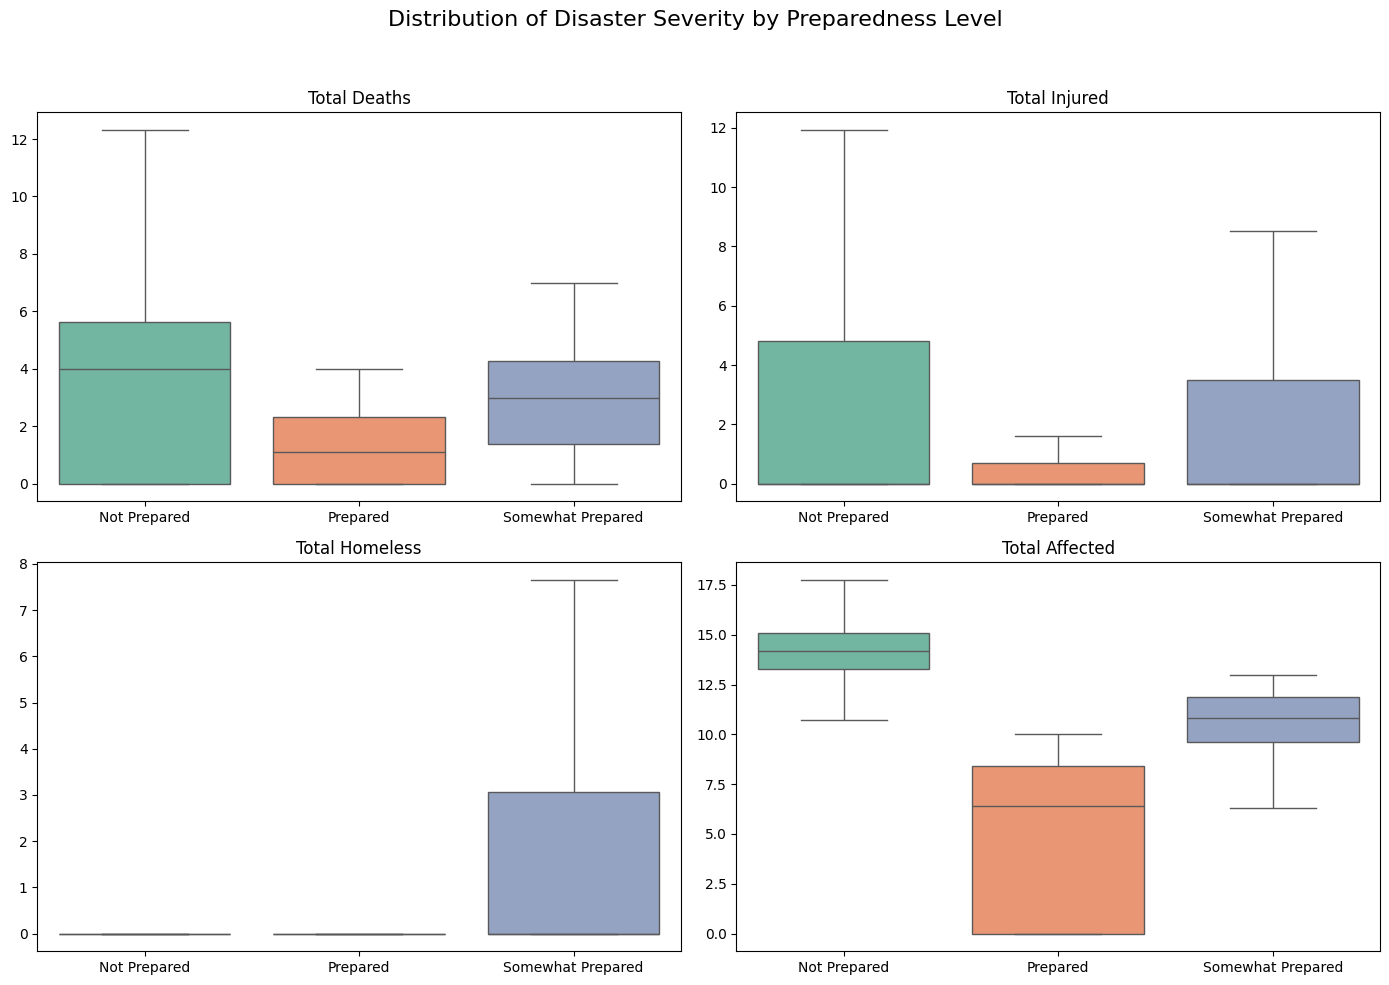

In [ ]:
# Set up 2x2 subplot for all four outcome variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Distribution of Disaster Severity by Preparedness Level", fontsize=16)

# Define titles and outcome variables
outcome_vars = ['Total_Deaths', 'Total_Injured', 'Total_Homeless', 'Total_Affected']
titles = ['Total Deaths', 'Total Injured', 'Total Homeless', 'Total Affected']

# Plot each boxplot
for ax, var, title in zip(axes.flatten(), outcome_vars, titles):
    sns.boxplot(data=df, x='Preparedness_Level', y=var, ax=ax, palette='Set2', showfliers=False)
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the combined figure
plt.savefig("disaster_severity_by_preparedness_boxplots.png", dpi=300, bbox_inches='tight')

plt.show()

**Interpretation of Results:**

The boxplots show clear stratification in disaster severity outcomes across preparedness levels. For **Total Deaths, Total Injured, and Total Affected**, countries categorized as **“Not Prepared”** consistently display the highest medians and widest spreads, indicating both severe and volatile impacts. **“Prepared”** countries exhibit the lowest medians and tight distributions, suggesting stronger capacity to contain disaster consequences. **“Somewhat Prepared”** countries again fall in between, but with closer alignment to the **“Not Prepared”** group in terms of both central tendency and spread, signaling limited effectiveness in partially prepared settings.

However, **Total Homeless** shows an unexpected pattern: the **“Somewhat Prepared”** group experiences **much higher and more variable levels of homelessness** than either of the other two. Both **“Prepared”** and **“Not Prepared”** groups show nearly flat distributions close to zero. This suggests that partially prepared governments may struggle with consistent shelter provision, while “Not Prepared” countries may lack systems to report or record displacement, or have lower exposure. This anomaly warrants further exploration in the qualitative discussion.

**Connection to Research Question:**

These findings reinforce the thesis claim that **government preparedness is strongly associated with reduced human harm in climate disasters**. Countries that demonstrate higher preparedness experience significantly fewer deaths, injuries, and affected populations. The sharp contrast between “Prepared” and “Not Prepared” nations in outcomes like deaths and injuries highlights the human rights implications of state capacity: governments that fail to prepare are far less able to protect life, health, and shelter in times of crisis.

The surprising homelessness trends in “Somewhat Prepared” countries suggest that **partial capacity without coherent response protocols may be especially dangerous**, leading to inconsistent or inadequate protection. This nuance highlights the importance of not just having institutions, but ensuring they function reliably in crisis. It also supports the broader human rights argument that **preparedness is not just a technical benchmark — it is a moral obligation tied to the right to life and dignity in disaster contexts**.

The findings affirm that **state preparedness correlates with reduced severity of disaster outcomes**, especially in terms of mortality, injury, and population-level disruption. The classification model captures this gradient of harm effectively, distinguishing between the protective strength of full preparedness and the vulnerabilities of weaker or partial systems. These results validate preparedness levels as a meaningful and scalable measure for evaluating human rights protection under crisis, offering practical utility for data-driven policy design.

##**Temporal Analysis of Government Preparedness (2000-2023)**

Grouping disaster events by year and computing the proportion of events falling into each preparedness category.

In [ ]:
# Group by Year and Preparedness Level
yearly_preparedness = (
    df.groupby(['Year', 'Preparedness_Level'])
      .size()
      .groupby(level=0)
      .apply(lambda x: x / x.sum())  # Normalize by year
      .unstack()
      .fillna(0)
      .reset_index(drop=True)  # This avoids trying to reinsert 'Year' again
)

# If keep 'Year' as a column, re-add it manually from the index:
yearly_preparedness['Year'] = df['Year'].unique()[:len(yearly_preparedness)]

# Preview the result
yearly_preparedness.head()

Preparedness_Level,Not Prepared,Prepared,Somewhat Prepared,Year
0,0.153846,0.560440,0.285714,2000
1,0.172043,0.553763,0.274194,2001
2,0.123153,0.576355,0.300493,2002
3,0.129730,0.524324,0.345946,2003
4,0.128492,0.614525,0.256983,2004


In [ ]:
# Reorder columns for clarity
cols = ['Year', 'Prepared', 'Somewhat Prepared', 'Not Prepared']
yearly_preparedness = yearly_preparedness[cols]

# Export to CSV
yearly_preparedness.to_csv("yearly_preparedness_distribution.csv", index=False)

Visualizing Trends Over Time

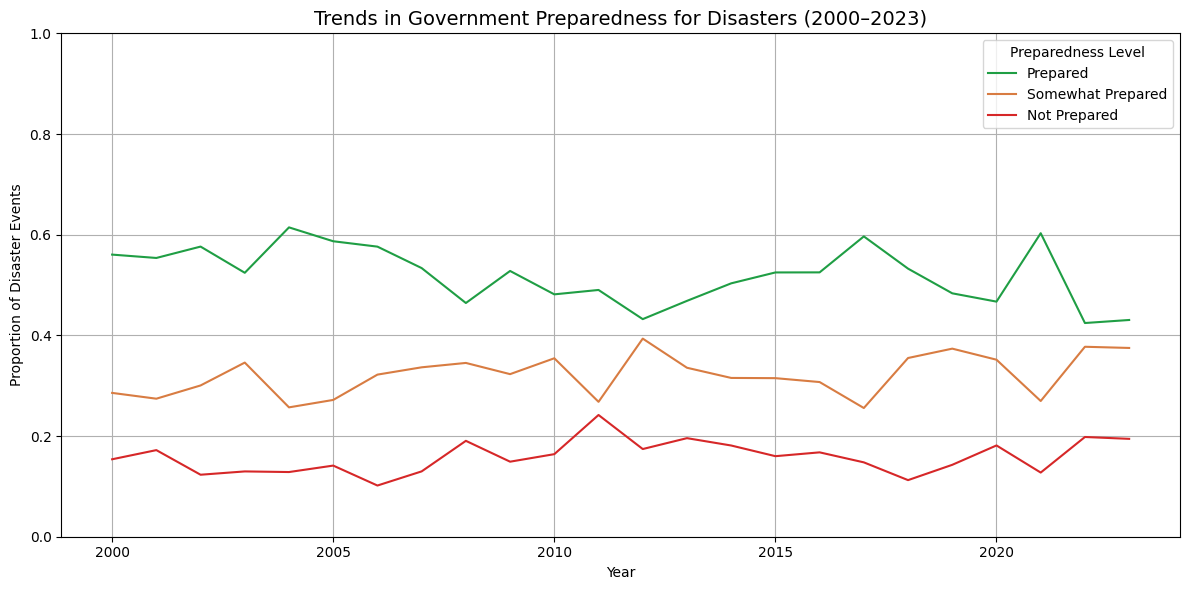

In [ ]:
# Define custom color palette
custom_colors = {
    'Prepared': '#1f9e44',           # green
    'Somewhat Prepared': '#d87c42',  # orange-brown
    'Not Prepared': '#d62728'        # red
}

# Plot Preparedness Proportions Over Time
plt.figure(figsize=(12, 6))

# Lineplot for each category
sns.lineplot(data=yearly_preparedness, x='Year', y='Prepared', label='Prepared', color=custom_colors['Prepared'])
sns.lineplot(data=yearly_preparedness, x='Year', y='Somewhat Prepared', label='Somewhat Prepared', color=custom_colors['Somewhat Prepared'])
sns.lineplot(data=yearly_preparedness, x='Year', y='Not Prepared', label='Not Prepared', color=custom_colors['Not Prepared'])

# Customize
plt.title('Trends in Government Preparedness for Disasters (2000–2023)', fontsize=14)
plt.ylabel('Proportion of Disaster Events')
plt.xlabel('Year')
plt.ylim(0, 1)
plt.grid(True)
plt.legend(title='Preparedness Level')
plt.tight_layout()


# Save the figure
plt.savefig("preparedness_trend.png", dpi=300, bbox_inches='tight')

plt.show()

**Interpretation of Results:**

Over the two-decade span, the proportion of disaster events occurring in **Prepared** contexts (blue line) consistently dominated, generally ranging between **45% and 60%**, though with some fluctuation over time. This reflects a relatively strong baseline of full preparedness globally, though the lack of a clear upward trajectory suggests that progress may have plateaued in recent years.

The **Somewhat Prepared** category (orange line) has shown a **gradual upward trend**, especially after 2015, rising from about **25% to over 35%** of disaster events. This increase could indicate a shift where more governments are achieving moderate levels of readiness without fully meeting the benchmarks for full preparedness—possibly signaling stalled progress or widening gaps between capability and crisis demands.

The **Not Prepared** category (green line) has remained **consistently low**, hovering around **10–20%** throughout the period. Its stability suggests that while a small subset of disaster responses remain critically underprepared, most countries avoid the lowest level of readiness. However, the lack of reduction over time also raises concerns about persistent vulnerabilities in a core group of countries.

**Connection to Research Question:**

These temporal patterns offer important context for addressing the thesis question—**“How effectively do governments protect fundamental human rights in climate disaster-prone regions?”**

While the consistently high share of Prepared disaster responses may seem encouraging, the **growing proportion of “Somewhat Prepared”** events signals a subtle but meaningful shift. It suggests that more governments are falling into a middle readiness zone—avoiding full unpreparedness but not reaching the standard needed to ensure the full protection of rights like life, housing, and access to aid.

This is particularly concerning from a rights-based perspective, as **partial preparedness may not provide sufficient institutional strength or reliability during crisis events**. Governments in the “Somewhat Prepared” category may struggle to deliver consistent protections, leaving affected populations at greater risk. These trends support the need for more ambitious standards and sustained investment in comprehensive disaster governance.

##**Disaster Type Breakdown by Preparedness Classification**

**Purpose:**

This section helps uncover **whether certain types of disasters are more common in countries that are Prepared, Somewhat Prepared, or Not Prepared.**

It answers questions like:
- Do floods tend to occur more in prepared countries?
- Are droughts more frequent where preparedness is lacking?
- Are certain disaster types more universally poorly managed?

**Hypothesis:**

Some disaster types may systematically cluster in less-prepared countries due to structural challenges (e.g., heatwaves and droughts in poorer regions), while others like storms may affect better-prepared coastal nations.


In [ ]:
# Create crosstab between Disaster Type and Preparedness Level
disaster_preparedness_crosstab = pd.crosstab(df['Disaster Type'], df['Preparedness_Level'])

# Normalize row-wise to show proportions
disaster_preparedness_percent = disaster_preparedness_crosstab.div(disaster_preparedness_crosstab.sum(axis=1), axis=0).round(2) * 100

# Preview the percentage table
disaster_preparedness_percent

Preparedness_Level,Not Prepared,Prepared,Somewhat Prepared
Disaster Type,,,
Drought,50.0,29.0,21.0
Earthquake,14.0,58.0,28.0
Extreme temperature,19.0,39.0,42.0
Flood,11.0,54.0,35.0
Storm,15.0,57.0,28.0
Wildfire,0.0,73.0,27.0


In [ ]:
# Export to CSV
disaster_preparedness_percent.to_csv("preparedness_by_disaster_type_percent.csv")

**Interpretation of Results:**

**Droughts** stand out: With 50% of events falling under Not Prepared, droughts have the weakest preparedness record. This suggests deeper structural issues, particularly in Global South countries where drought resilience infrastructure may be limited.

**Extreme temperatures** show a more even split, with the highest share falling under Somewhat Prepared. This could reflect the increasing frequency and unpredictability of heatwaves, where governments may have some preparedness measures in place but struggle with full-scale response systems.

**Wildfires, earthquakes and storms**, by contrast, are overwhelmingly managed by Prepared states—likely countries with more resources and disaster planning capacity.

**Connection to Research Question:**

**“How effectively do governments protect fundamental human rights in climate disaster-prone regions, and how can data science models assess and improve state preparedness?”**

This breakdown speaks directly to **variation in state capacity**:
- Certain disaster types (e.g., wildfires, earthquakes and storms) are more likely to be addressed with strong preparedness systems that may protect the right to life, shelter, and health.
- Others (e.g., droughts, extreme temperatures) reveal significant gaps, where a lack of full preparedness can leave populations at greater risk of harm and displacement.

This also reinforces the need for **tailored preparedness strategies**—what works for storms may not be sufficient for droughts or heatwaves, especially under climate change.

##**Cosstab of Disaster Type per Preparedness Level per Region**

Calculating how each region handles each disaster type, showing what proportions falls under **Not Prepared**, **Somewhat Prepared**, and **Prepared**.

In [ ]:
# Crosstab between Disaster Type and Preparedness Level, grouped by Region
regional_disaster_crosstab = pd.crosstab(
    index=[df['Region'], df['Disaster Type']],
    columns=df['Preparedness_Level'],
    normalize='index'  # Normalize within each Region-Disaster Type group
).round(2)

# View the table
regional_disaster_crosstab

Preparedness_Level            Not Prepared  Prepared  Somewhat Prepared
Region   Disaster Type                                                 
Africa   Drought                      0.73      0.08               0.20
         Earthquake                   0.07      0.79               0.14
         Extreme temperature          0.00      0.71               0.29
         Flood                        0.07      0.47               0.46
         Storm                        0.13      0.56               0.31
         Wildfire                     0.00      0.38               0.62
Americas Drought                      0.18      0.50               0.32
         Earthquake                   0.11      0.67               0.22
         Extreme temperature          0.00      0.54               0.46
         Flood                        0.06      0.59               0.36
         Storm                        0.09      0.64               0.27
         Wildfire                     0.00      0.71               0.29
Asia     Drought                      0.64      0.23               0.13
         Earthquake                   0.19      0.47               0.33
         Extreme temperature          0.18      0.41               0.41
         Flood                        0.23      0.39               0.38
         Storm                        0.26      0.40               0.34
         Wildfire                     0.00      0.86               0.14
Europe   Drought                      0.04      0.85               0.12
         Earthquake                   0.03      0.68               0.29
         Extreme temperature          0.23      0.35               0.43
         Flood                        0.01      0.86               0.13
         Storm                        0.00      1.00               0.00
         Wildfire                     0.00      0.90               0.10
Oceania  Drought                      0.06      0.76               0.18
         Earthquake                   0.05      0.75               0.20
         Extreme temperature          0.00      0.50               0.50
         Flood                        0.00      0.87               0.13
         Storm                        0.02      0.74               0.25
         Wildfire                     0.00      1.00               0.00

In [ ]:
# Export to CSV
regional_disaster_crosstab.to_csv("preparedness_by_disaster_type_and_region_percent.csv")

**Interpretation of Results:**

The table reveals distinct regional disparities in preparedness for different disaster types:
- **Africa** shows particularly low preparedness for droughts, with 73% of events occurring in countries classified as Not Prepared. While Africa performs better in handling earthquakes and wildfires, around one-third of floods and storms still fall under low or medium preparedness, suggesting uneven capacity depending on hazard type.
- **Asia** follows a similar pattern, with high unpreparedness for droughts (64%) and moderate gaps for floods, storms, and extreme temperatures. While wildfire preparedness is high (86%), responses to earthquakes and extreme heat are much more varied.
- **The Americas** display generally strong disaster preparedness, especially for wildfires (71% Prepared) and earthquakes (67% Prepared). However, droughts still pose challenges (only 50% Prepared).
- **Europe** is consistently strong in preparedness, with nearly all events classified under Prepared for floods (86%), storms (100%), and droughts (85%). One exception is extreme temperature events, where 23% fall under Not Prepared.
- **Oceania** demonstrates high preparedness across all disaster types, particularly for wildfires (100%), storms (74%), and earthquakes (75%), though some room for improvement exists in handling extreme temperatures (50% split between Prepared and Somewhat Prepared).

**Connection to Research Question:**

This analysis directly supports the thesis inquiry on **how effectively governments protect fundamental human rights in climate disaster-prone regions**. It highlights that low preparedness is not uniformly distributed, but is instead highly dependent on both **disaster type** and **regional context**.

Regions like **Africa and Asia** are systematically underprepared for slow-onset disasters like **droughts** and **extreme heat**, which disproportionately threaten access to **water, food, shelter, and health services**—all core human rights. In contrast, more resource-rich regions like **Europe and Oceania** show near-universal preparedness for most disaster types, underscoring global inequalities in protective governance.

These findings strengthen the argument that **human rights risks are elevated not just by the frequency of disasters, but by the mismatch between hazard type and institutional preparedness capacity**, and this mismatch is geographically patterned.

##**Crosstab of Disaster Type per Preparedness Level per Subregion**

Computing preparedness by **Subregion** and **Disaster Type** to spot more localized disparities.

In [ ]:
# Subregional crosstab: Preparedness Level by Subregion and Disaster Type
subregional_disaster_crosstab = pd.crosstab(
    index=[df['Subregion'], df['Disaster Type']],
    columns=df['Preparedness_Level'],
    normalize='index'  # Normalize within each Subregion–Disaster Type group
).round(2)

# Display full subregional crosstab
pd.set_option('display.max_rows', None)  # Show all rows
display(subregional_disaster_crosstab)

# Export the subregional disaster crosstab to CSV
subregional_disaster_crosstab.to_csv("subregional_preparedness_by_disaster.csv")

Preparedness_Level                                   Not Prepared  Prepared  \
Subregion                       Disaster Type                                 
Australia and New Zealand       Drought                      0.00      1.00   
                                Earthquake                   0.00      0.50   
                                Extreme temperature          0.00      0.50   
                                Flood                        0.00      0.95   
                                Storm                        0.00      0.85   
                                Wildfire                     0.00      1.00   
Central Asia                    Drought                      0.80      0.00   
                                Earthquake                   0.00      0.85   
                                Extreme temperature          0.00      1.00   
                                Flood                        0.00      0.81   
                                Wildfire                     0.00      1.00   
Eastern Asia                    Drought                      0.82      0.18   
                                Earthquake                   0.27      0.37   
                                Extreme temperature          0.35      0.50   
                                Flood                        0.29      0.40   
                                Storm                        0.20      0.46   
                                Wildfire                     0.00      1.00   
Eastern Europe                  Drought                      0.09      0.82   
                                Earthquake                   0.00      0.78   
                                Extreme temperature          0.20      0.36   
                                Flood                        0.01      0.78   
                                Storm                        0.00      1.00   
                                Wildfire                     0.00      1.00   
Latin America and the Caribbean Drought                      0.20      0.45   
                                Earthquake                   0.13      0.64   
                                Extreme temperature          0.00      1.00   
                                Flood                        0.06      0.55   
                                Storm                        0.09      0.62   
                                Wildfire                     0.00      0.78   
Melanesia                       Drought                      0.33      0.33   
                                Earthquake                   0.08      0.85   
                                Flood                        0.00      0.73   
                                Storm                        0.05      0.54   
Micronesia                      Drought                      0.00      0.67   
                                Flood                        0.00      1.00   
                                Storm                        0.00      0.82   
Northern Africa                 Drought                      1.00      0.00   
                                Earthquake                   0.25      0.62   
                                Extreme temperature          0.00      0.80   
                                Flood                        0.05      0.60   
                                Storm                        0.00      0.80   
                                Wildfire                     0.00      0.00   
Northern America                Drought                      0.00      0.85   
                                Earthquake                   0.00      0.90   
                                Extreme temperature          0.00      0.45   
                                Flood                        0.02      0.83   
                                Storm                        0.08      0.70   
                                Wildfire                     0.00      0.67   
Northern Europe                 Drought           

**Interpretation of Results:**

The subregional crosstab reveals striking disparities in how different parts of the world handle specific types of disasters:
- **Droughts** are **consistently underprepared for** in several subregions:
	- South-central Asia, Northern Africa, and Sub-Saharan Africa all show **>majority of droughts** falling in the **“Not Prepared”** category.
	- In contrast, subregions like Northern Europe, Southern Europe, and Australia and New Zealand report **high preparedness** for droughts.
- **Extreme temperatures** also show a wide range of preparedness:
	- Southern Asia and Eastern Asia show low levels of preparedness (Not Prepared > 30%).
	- Northern Europe has a relatively high rate of “Somewhat Prepared” (62%), hinting at partial infrastructure or planning challenges.
- **Earthquakes** tend to have **higher preparedness overall**, especially in:
	- Western Europe, Melanesia, and Northern America, all showing 100% or near-100% preparedness.
	- However, Southern Asia and Eastern Asia still show a mix, classified as Not or Somewhat Prepared.
- **Floods and storms** show more uniform preparedness across most subregions:
	- Especially high in Europe, Oceania, and North America, with almost all events falling under “Prepared.”
	- Exceptions include Southern Asia (over 30% of floods and storms unprepared-for) and Sub-Saharan Africa (moderate levels of unpreparedness).

**Connection to Research Question:**

The thesis seeks to understand how well governments protect fundamental human rights in disaster-prone regions — and this subregional breakdown offers direct insight:
- **Drought preparedness** remains a **key vulnerability** in regions like **Northern Africa**, **South-central Asia**, and **Sub-Saharan Africa**, where failure to anticipate water scarcity can lead to rights violations related to **food, water, health, and life**.
- The fact that **some regions are systematically unprepared** for certain disasters suggests **structural inequalities**, where national or subregional capacities (e.g. budget, infrastructure, climate adaptation) may not align with rising climate risks.
- **Localized disparities** also support the use of a **granular**, **subregional lens** in the thesis — it’s not just which countries are prepared, but **where, and for what type of hazard**, that drives outcomes in terms of displaced populations, injuries, and deaths.


##**Crosstab of Disaster Type per Preparedness Level per Country**

Computing preparedness by **Country** and **Disaster Type** to spot more localized disparities.

In [ ]:
# Crosstab: Preparedness by Country and Disaster Type
country_disaster_crosstab = pd.crosstab(
    index=[df['Country'], df['Disaster Type']],
    columns=df['Preparedness_Level'],
    normalize='index'  # Normalize within each Country–Disaster Type group
).round(2)

country_disaster_crosstab.to_csv("country_preparedness_by_disaster.csv")

# View the full table
country_disaster_crosstab

Preparedness_Level                                                      Not Prepared  \
Country                                            Disaster Type                       
Afghanistan                                        Drought                      0.83   
                                                   Earthquake                   0.23   
                                                   Flood                        0.00   
Albania                                            Earthquake                   0.00   
                                                   Extreme temperature          0.00   
                                                   Flood                        0.00   
Algeria                                            Earthquake                   0.20   
                                                   Extreme temperature          0.00   
                                                   Flood                        0.00   
                                                   Wildfire                     0.00   
American Samoa                                     Earthquake                   0.00   
                                                   Flood                        0.00   
                                                   Storm                        0.00   
Angola                                             Drought                      0.60   
                                                   Flood                        0.04   
Anguilla                                           Storm                        0.00   
Antigua and Barbuda                                Storm                        0.00   
Argentina                                          Drought                      0.00   
                                                   Earthquake                   0.00   
                                                   Flood                        0.00   
                                                   Storm                        0.00   
                                                   Wildfire                     0.00   
Armenia                                            Drought                      0.00   
                                                   Flood                        0.00   
                                                   Storm                        0.00   
Australia                                          Drought                      0.00   
                                                   Extreme temperature          0.00   
                                                   Flood                        0.00   
                                                   Storm                        0.00   
                                                   Wildfire                     0.00   
Austria                                            Extreme temperature          0.00   
                                                   Flood                        0.00   
                                                   Storm                        0.00   
Azerbaijan                                         Drought                      0.00   
                                                   Earthquake                   0.00   
                                                   Flood                        0.00   
Bahamas                                            Flood                        0.00   
                                                   Storm                        0.00   
Bangladesh                                         Drought                      0.00   
                                                   Earthquake                   0.00   
                                                   Extreme temperature          0.00   
                                                   Flood                        0.65   
                                                   Storm                        0.35   
Barbados                                

**Interpretation of Results:**

**High Preparedness Countries:**
- **Japan** remains a strong example of earthquake preparedness, with nearly all earthquake events falling under the Prepared category—reflecting robust seismic planning and infrastructure.
- The **United States** shows high preparedness for storms and floods, but lower readiness for droughts, where a notable share of events fall under Not Prepared.
- **Australia and New Zealand** demonstrate high wildfire preparedness (up to 90%), which aligns with their advanced fire management and early response systems.

**Countries with Moderate Preparedness:**
- **India** exhibits mixed performance. While storms are highly managed (78% Prepared), droughts remain a key weakness (over 80% Not Prepared).
- **Mexico** and **Indonesia** show solid readiness for storms and earthquakes, but their preparedness for droughts and extreme temperatures is more limited, reflecting imbalanced disaster management strategies.

**Countries with Low Preparedness:**
- **Zimbabwe** is significantly underprepared for droughts (83% Not Prepared), and only modestly prepared for floods.
- **Nigeria** and **Ethiopia** remain highly vulnerable to droughts, with 50–60% of related disasters classified as Not Prepared, posing threats to food and water security.
- **Bangladesh**, despite its storm-readiness, struggles with extreme temperatures and floods, putting millions—especially those in low-lying areas—at risk.
- In **Somalia**, floods and droughts continue to be poorly managed, likely exacerbating humanitarian risks due to weak governance structures.


**Connection to Research Question:**

The results strengthen the thesis inquiry into **how effectively governments protect fundamental human rights in climate disaster-prone regions**. Country-level variation offers three key insights:

**Impact on Human Rights**:
Countries with low preparedness for droughts, floods, and extreme temperatures often fail to protect basic rights such as the **right to life, food, water, and shelter**.
- For instance, **Zimbabwe** and **Nigeria’s** severe drought unpreparedness signals high risk of **food and water insecurity**, threatening the right to adequate nutrition and hydration.
- **Bangladesh**, while strong on storms, exhibits inadequate flood and heat preparedness—amplifying **displacement and shelter insecurity**, especially for vulnerable populations in coastal areas.

**Regional Disparities:**
These findings reveal **global inequalities** in preparedness. Lower-income and climate-vulnerable countries often lag behind in managing slow-onset and compounding disasters (like droughts and heatwaves), not due to a lack of urgency, but due to structural limitations in **infrastructure, governance, and long-term capacity building**.

**Preparedness as a Rights Indicator**:
Low preparedness in countries like **Somalia**, **Ethiopia**, and **Zimbabwe** signals more than a policy gap—it marks a **systemic human rights risk**. Without functioning disaster management systems, governments may be **unable to fulfill their obligations** to protect life and dignity during crises.

##**Clustering Countries Based on Preparedness Patterns**

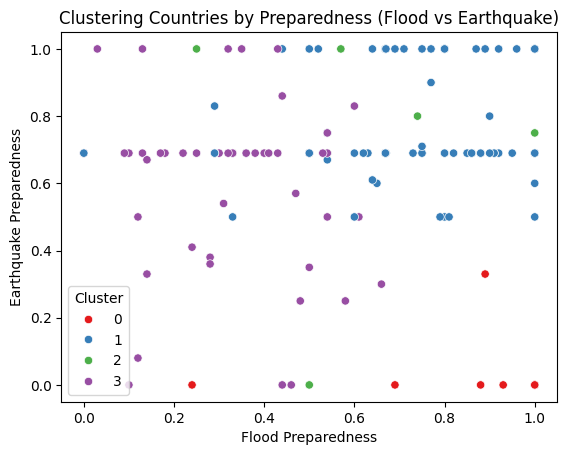

,Cluster
Country,
Afghanistan,3
Albania,1
Algeria,2
American Samoa,1
Angola,3


In [ ]:
# Load the preparedness data from CSV
df_preparedness = pd.read_csv("country_preparedness_by_disaster.csv")

# Reshape the data to get preparedness levels by disaster type for each country
df_preparedness_pivot = df_preparedness.pivot_table(
    index='Country',
    columns='Disaster Type',
    values=['Not Prepared', 'Prepared', 'Somewhat Prepared'],
    aggfunc='mean'
)

# Flatten the column names (multi-level columns to single-level)
df_preparedness_pivot.columns = ['_'.join(col) for col in df_preparedness_pivot.columns]

# Handle missing values (fill with mean of the column)
df_preparedness_pivot = df_preparedness_pivot.fillna(df_preparedness_pivot.mean())

# Normalize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_preparedness_pivot)

# Apply KMeans with optimal clusters (based on Elbow method result)
optimal_n_clusters = 4  # Assume 4 from the elbow method
kmeans = KMeans(n_clusters=optimal_n_clusters, init='k-means++', max_iter=300, n_init=10)
df_preparedness_pivot['Cluster'] = kmeans.fit_predict(features_scaled)

# Visualize the clusters using seaborn
sns.scatterplot(x='Prepared_Flood', y='Prepared_Earthquake', hue='Cluster', palette='Set1', data=df_preparedness_pivot)
plt.title('Clustering Countries by Preparedness (Flood vs Earthquake)')
plt.xlabel('Flood Preparedness')
plt.ylabel('Earthquake Preparedness')
plt.legend(title='Cluster')

plt.savefig("preparedness_clusters_flood_vs_earthquake.png", dpi=300)

plt.show()

# Preview the first few rows of clusters and their corresponding countries
df_preparedness_pivot[['Cluster']].head()

**Interpretation of Results:**

In [ ]:
# Export the full table with cluster assignments
df_preparedness_pivot.to_csv("country_preparedness_clusters.csv")

The K-Means clustering algorithm has grouped countries based on their preparedness for **Floods** and **Earthquakes**, resulting in four distinct clusters. The visualization shows that most countries are located in one of four groups, each with different levels of preparedness for these natural disasters.
- **Cluster 0 (Red)**: This group consists of countries with relatively low preparedness for both floods and earthquakes. These countries are the most vulnerable to both types of disasters and may need immediate attention in terms of disaster management, infrastructure improvements, and policy interventions.
- **Cluster 1 (Blue)**: Countries in this cluster have moderate to high preparedness for earthquakes but relatively lower preparedness for floods. These countries may have focused their disaster management efforts more on seismic activities, leaving them more vulnerable to flooding risks. These countries might benefit from increased flood preparedness to mitigate the risks associated with floods.
- **Cluster 2 (Green)**: This group consists of countries that have balanced preparedness for both floods and earthquakes. These countries have implemented strong disaster management strategies for both types of disasters, placing them in a relatively safer position when it comes to handling both flood and earthquake events.
- **Cluster 3 (Purple)**: Countries in this cluster exhibit high preparedness for floods but comparatively lower preparedness for earthquakes. These countries have focused more on flood management, likely due to higher exposure to flood-prone areas or historical patterns. However, they may need to invest more in earthquake resilience, especially if they are in seismically active regions.

**Connection to Research Question:**

The analysis of disaster preparedness through clustering is directly connected to the research question: **“How effectively do governments protect fundamental human rights in climate disaster-prone regions, and how can data science models assess and improve state preparedness?”**

**Clustering Analysis as an Assessment Tool:**
- The clustering method provides a way to assess the **preparedness levels of different countries** in terms of their disaster management systems, specifically for **Floods** and **Earthquakes**. This approach aligns with the research question by evaluating how prepared governments are to handle these disasters, which in turn impacts the protection of fundamental human rights, such as the right to life, health, and shelter.

**Linking Preparedness to Human Rights Protection**:
- The results highlight that countries with **low preparedness** (Cluster 0) are particularly vulnerable to human rights violations during disasters, as they lack the infrastructure and resources to protect their citizens during such events. The **unpreparedness for both floods and earthquakes** increases the likelihood of severe consequences for the population, including deaths, displacement, and loss of livelihood. This is critical in understanding the extent to which governments are meeting their responsibility to protect human rights in disaster-prone regions.

**Impact of Disaster Type Focus**:
- The clusters also indicate that countries with a strong focus on one type of disaster (e.g., Cluster 1, which is more prepared for earthquakes) may be overlooking others (such as floods). This selective preparedness could lead to human rights violations in the context of the neglected disaster type. The research question emphasizes understanding how governments can improve preparedness in a balanced way to better protect citizens’ rights, especially in regions vulnerable to multiple disaster types.

**Opportunities for Improvement**:
- The analysis suggests that countries in **Cluster 1** and **Cluster 3** may benefit from a more **holistic approach** to disaster management. For example, **Cluster 1 countries** could improve flood management policies, while **Cluster 3 countries** may need to focus more on earthquake resilience. Enhancing preparedness for both types of disasters in these regions will directly contribute to safeguarding the **right to life** and the **right to shelter** during disaster events.

In conclusion, the K-Means clustering approach provides valuable insights into **country-level preparedness** and its relationship to human rights protection in disaster-prone regions. The results emphasize the importance of balanced preparedness strategies to mitigate the impacts of natural disasters on fundamental rights, directly informing the research question by offering data-driven insights into government preparedness and its role in human rights protection.

##**Temporal Trends in Preparedness: Analyzing Changes Over Time**

In this enhancement, we will analyze how preparedness levels for different types of disasters (e.g., floods, earthquakes) have changed over time. By focusing on the years 2000 to 2023, we aim to assess whether countries that were unprepared for certain disasters in 2000 have made improvements by 2023. This temporal trend analysis will provide insights into the effectiveness of government preparedness strategies and can help us understand whether the global response to climate disasters is improving or not over time.

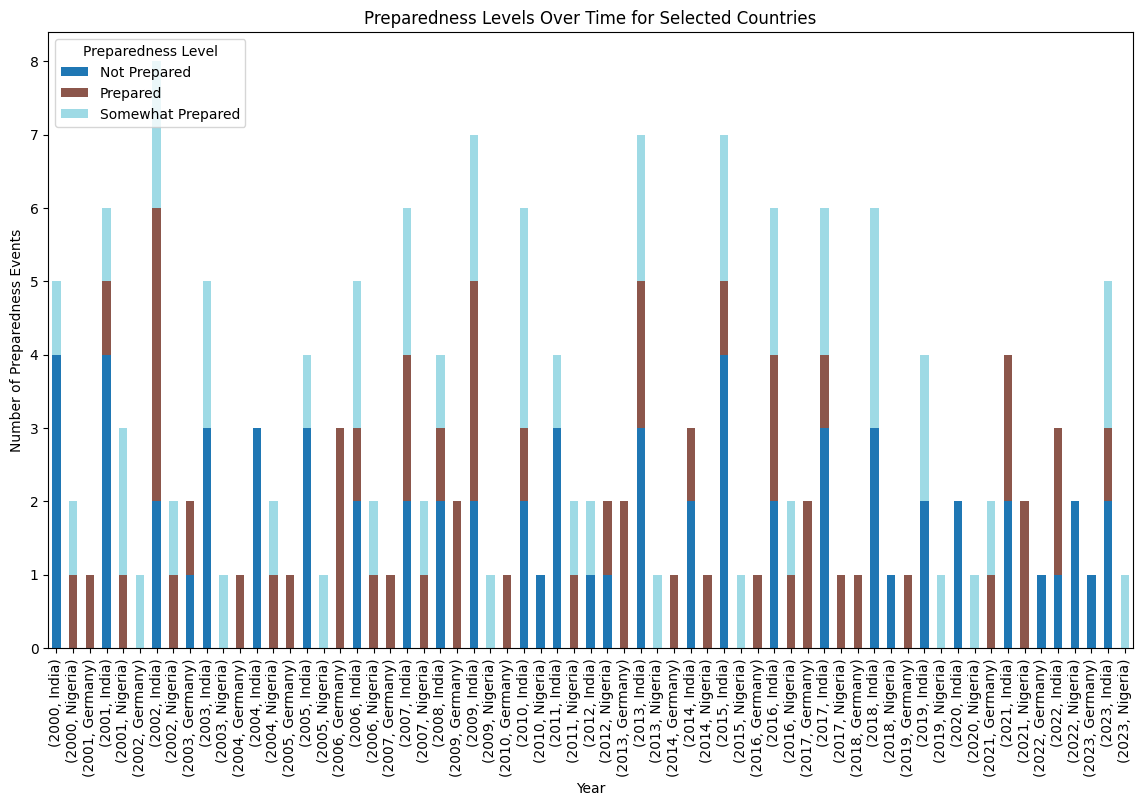

In [ ]:
# Group the data by Country, Year, and Preparedness Level to calculate the count of preparedness levels
df_temporal = df.groupby(['Country', 'Year', 'Preparedness_Level']).size().reset_index(name='Count')

# Select the countries to analyze
selected_countries = ['Germany', 'India', 'Nigeria']  # Example countries
df_temporal_selected = df_temporal[df_temporal['Country'].isin(selected_countries)]

# Pivot the data to get preparedness level counts for each country by year
df_temporal_pivot = df_temporal_selected.pivot_table(index=['Year', 'Country'], columns='Preparedness_Level', values='Count', aggfunc='sum').reset_index()

# Plotting the stacked bar plot with different colors for each country
df_temporal_pivot.set_index(['Year', 'Country'], inplace=True)
df_temporal_pivot.plot(kind='bar', stacked=True, figsize=(14, 8), cmap='tab20')

# Adding titles and labels
plt.title('Preparedness Levels Over Time for Selected Countries')
plt.xlabel('Year')
plt.ylabel('Number of Preparedness Events')
plt.legend(title='Preparedness Level', loc='upper left')

# Save figure
plt.savefig("Temporal_Trends_Preparedness_Selected_Countries.png", dpi=300)

plt.show()

**Interpretation of Results**

The stacked bar chart above illustrates the preparedness levels of Germany, India, and Nigeria from 2000 to 2023. The color segments represent the three levels of preparedness: **Not Prepared** (dark blue), **Prepared** (brown), and **Somewhat Prepared** (light blue).

The trends reveal that **India** demonstrates the most consistent improvement, with the light blue (Somewhat Prepared) segments dominating the chart from around 2010 onwards, indicating steady, albeit partial, gains in preparedness.

**Germany**, in contrast, shows a mixed but moderately stable pattern, with a blend of brown (Prepared) and light blue (Somewhat Prepared) distributed throughout the years—suggesting fluctuating commitment to full preparedness. Although Germany’s share of “Prepared” events is visible, it is not overwhelmingly dominant across the timeline.

**Nigeria** exhibits the greatest variability and lower preparedness overall. The chart shows frequent dark blue bars (Not Prepared) across many years, with only scattered years reflecting light blue (Somewhat Prepared) or brown (Prepared). While there are some signs of improvement after 2015, the dominance of dark blue indicates persistent vulnerabilities in the country’s disaster readiness. Overall, while all three countries have shown moments of progress, India appears to have made the most consistent shift upward in preparedness, followed by Germany staying consistent in shifting between being prepared and somewhat prepared, while Nigeria remains the least consistently prepared.

**Connection to Research Question:**

This analysis directly informs the research question on how effectively governments protect human rights in disaster-prone contexts by comparing evolving preparedness levels in India, Germany, and Nigeria. India’s steady rise in “Somewhat Prepared” (light blue) events since 2010 suggests a clear governmental effort to improve disaster readiness—an encouraging trend for safeguarding rights such as life, health, and shelter. However, the limited presence of fully “Prepared” (brown) events signals that India still faces systemic challenges in reaching full preparedness.

Germany’s alternating pattern between “Prepared” and “Somewhat Prepared” levels reflects moderate but inconsistent preparedness, pointing to potential variation in disaster type focus or implementation strength across different years. Meanwhile, Nigeria’s repeated occurrence of “Not Prepared” (dark blue) bars underscores significant gaps in disaster governance. The infrequent shift toward “Somewhat Prepared” and “Prepared” events indicates that improvements have been limited and uneven.

By visualizing these country-level trends over time, the chart highlights how differences in state capacity and policy consistency shape disaster preparedness and, by extension, human rights protection. Understanding these dynamics is crucial for identifying best practices and areas of concern in global preparedness strategies.

##**Disaster-Specific Preparedness Analysis: Investigating Focus Areas**

This enhancement explores the variation in preparedness levels by disaster type (e.g., floods, earthquakes, extreme temperatures) to assess whether certain governments prioritize specific types of disasters over others. By breaking down preparedness levels by disaster type, the analysis will reveal if some countries are better prepared for certain risks, potentially overlooking others. For example, a government might be well-prepared for earthquakes but underprepared for floods or heatwaves, suggesting a misalignment between their preparedness strategies and actual disaster risks. This disaster-specific analysis will help highlight areas where governments may need to improve their preparedness strategies, ultimately informing more comprehensive disaster management policies.

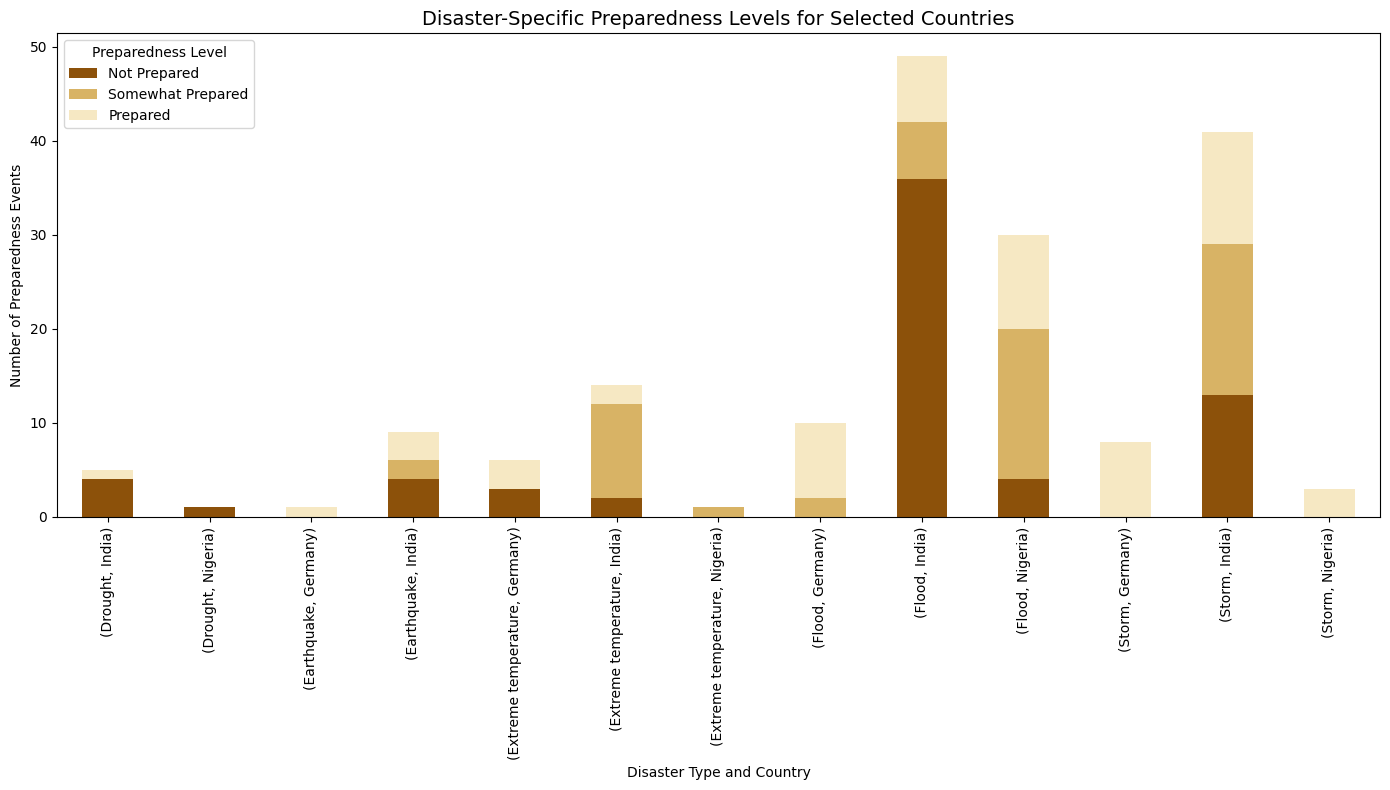

In [ ]:
# Group the data by Country, Disaster Type, and Preparedness Level
df_disaster_specific = df.groupby(['Country', 'Disaster Type', 'Preparedness_Level']).size().reset_index(name='Count')

# Select the countries to analyze
selected_countries = ['Germany', 'India', 'Nigeria']  # Adjust as needed
df_disaster_specific_selected = df_disaster_specific[df_disaster_specific['Country'].isin(selected_countries)]

# Pivot the data
df_disaster_specific_pivot = df_disaster_specific_selected.pivot_table(
    index=['Disaster Type', 'Country'],
    columns='Preparedness_Level',
    values='Count',
    aggfunc='sum'
).fillna(0)

# Define earthy color palette
earthy_colors = {
    'Not Prepared': '#8c510a',       # dark brown
    'Somewhat Prepared': '#d8b365',  # sand tan
    'Prepared': '#f6e8c3'            # light beige
}

# Plot the stacked bar chart
df_disaster_specific_pivot[['Not Prepared', 'Somewhat Prepared', 'Prepared']].plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    color=[earthy_colors['Not Prepared'],
           earthy_colors['Somewhat Prepared'],
           earthy_colors['Prepared']]
)

# Customize the chart
plt.title('Disaster-Specific Preparedness Levels for Selected Countries', fontsize=14)
plt.xlabel('Disaster Type and Country')
plt.ylabel('Number of Preparedness Events')
plt.legend(title='Preparedness Level', loc='upper left')
plt.tight_layout()

# Save the figure
plt.savefig("Disaster_Specific_Preparedness.png", dpi=300)

# Show plot
plt.show()

**Interpretation of Results:**

The stacked bar chart illustrates disaster-specific preparedness levels for Germany, India, and Nigeria across different types of disasters from 2000 to 2023. The colors represent three categories: **Not Prepared** (dark blue), **Prepared** (brown), and **Somewhat Prepared** (light blue). The results reveal distinct patterns among the countries. Germany consistently shows strong preparedness across disaster types, with notably high “Prepared” levels for **floods**, **storms**, and **extreme temperatures**, suggesting robust and well-resourced disaster planning infrastructure.

India, by contrast, exhibits a heavy reliance on the **“Somewhat Prepared”** category across most disaster types, especially **floods**, **droughts**, and **extreme temperatures**. This suggests that while the country may have developed some response mechanisms, it still struggles to reach full preparedness across disaster categories.

Nigeria’s profile is marked by a high share of **“Not Prepared”** classifications for disasters such as **droughts**, **earthquakes**, and **storms**, although more recent data show some increase in **“Prepared”** status for **floods** and **storms**. This points to slow but emerging improvements in targeted disaster response, despite continuing vulnerabilities in core areas like drought and earthquake resilience.

**Connection to Research Question:**

This analysis directly supports the research question on how governments protect fundamental human rights in climate disaster-prone contexts by comparing their preparedness across specific disaster types. By examining the varying levels of readiness across Germany, India, and Nigeria, we gain insight into how governments prioritize certain risks and where systemic gaps may exist.

Germany’s emphasis on high preparedness across flood-related and temperature-related disasters suggests strong institutional mechanisms for risk mitigation. India’s dominant classification under “Somewhat Prepared” across multiple disaster types indicates ongoing challenges in translating mid-level preparedness into full resilience, which can affect the consistent protection of rights like shelter, health, and aid. Nigeria’s preparedness profile—dominated by “Not Prepared” levels, especially for drought and earthquake—points to deeper governance and infrastructure constraints, which likely exacerbate rights risks during crises.

Ultimately, these variations underscore the need for differentiated policy responses. Countries like India may benefit from strategies that help them transition from “Somewhat Prepared” to “Prepared,” while countries like Nigeria require foundational investments to move out of “Not Prepared” status. The comparative view also reinforces how disaster-specific preparedness is inseparable from human rights protection, particularly in climate-vulnerable settings.

##**Disaster Preparedness Levels By Region**

This analysis expands the focus on disaster preparedness to include regional comparisons, specifically evaluating how different regions (Africa, Asia, Europe, etc.) are prepared for a variety of disaster types.

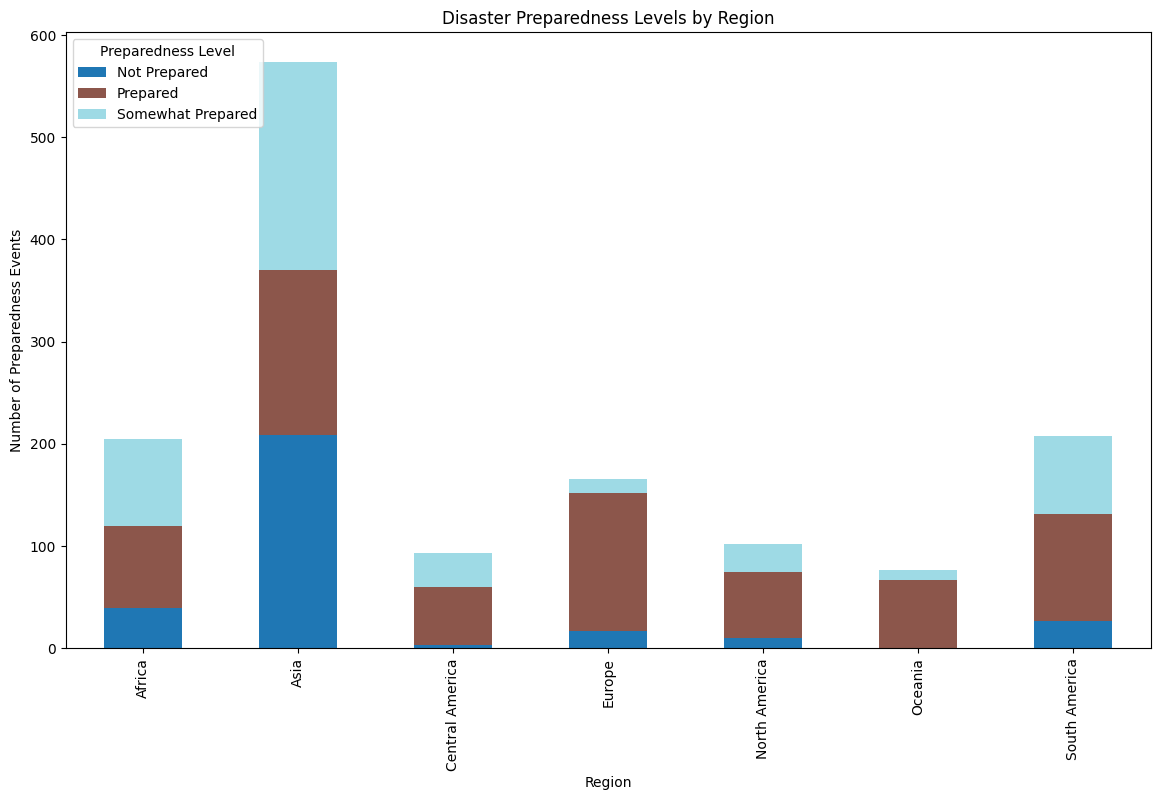

In [ ]:
# Group countries by region
region_mapping = {
    # Europe
    'Germany': 'Europe', 'France': 'Europe', 'Italy': 'Europe', 'Spain': 'Europe',
    'United Kingdom': 'Europe', 'Netherlands': 'Europe', 'Poland': 'Europe',

    # Asia
    'India': 'Asia', 'China': 'Asia', 'Japan': 'Asia', 'Indonesia': 'Asia',
    'South Korea': 'Asia', 'Pakistan': 'Asia', 'Bangladesh': 'Asia',

    # Africa
    'Nigeria': 'Africa', 'South Africa': 'Africa', 'Egypt': 'Africa',
    'Kenya': 'Africa', 'Ethiopia': 'Africa', 'Ghana': 'Africa', 'Uganda': 'Africa',

    # North America
    'United States': 'North America', 'Canada': 'North America', 'Mexico': 'North America',

    # South America
    'Brazil': 'South America', 'Argentina': 'South America', 'Colombia': 'South America',
    'Chile': 'South America', 'Peru': 'South America',

    # Oceania
    'Australia': 'Oceania', 'New Zealand': 'Oceania',

    # Central America
    'Costa Rica': 'Central America', 'Panama': 'Central America', 'Honduras': 'Central America'
}

# Assign the region to each country
df['Region'] = df['Country'].map(region_mapping)

# Group by Region and Preparedness Level to calculate counts
df_region = df.groupby(['Region', 'Preparedness_Level']).size().reset_index(name='Count')

# Pivot the data to prepare it for stacked bar plot
df_region_pivot = df_region.pivot_table(index='Region', columns='Preparedness_Level', values='Count', aggfunc='sum').reset_index()

# Plot the stacked bar plot by region
df_region_pivot.set_index('Region', inplace=True)
df_region_pivot.plot(kind='bar', stacked=True, figsize=(14, 8), cmap='tab20')

# Adding titles and labels
plt.title('Disaster Preparedness Levels by Region')
plt.xlabel('Region')
plt.ylabel('Number of Preparedness Events')
plt.legend(title='Preparedness Level', loc='upper left')

# Save the figure
plt.savefig("preparedness_by_region_stacked_bar.png", dpi=300)

plt.show()

In [ ]:
# Check the unique regions in the dataset after the assignment
df['Region'].value_counts()

,count
Region,
Asia,574
South America,208
Africa,205
Europe,166
North America,102
Central America,93
Oceania,77


**Interpretation of Results:**

The bar chart illustrates regional differences in disaster preparedness levels across seven world regions, broken down by the number of disaster events classified as **Not Prepared** (dark blue), **Prepared** (brown), and **Somewhat Prepared** (light blue). Asia stands out with the highest volume of disaster events (574), revealing a wide distribution across all three preparedness levels. Notably, Asia exhibits a large number of events in both the **Prepared** and **Not Prepared** categories, highlighting disparities in response capacity within the region. In contrast, **Africa**, with a much lower event count (205), shows a greater concentration of **Not Prepared** classifications, indicating significant preparedness deficits. **Europe** and **North America** exhibit relatively higher proportions of **Prepared** responses despite lower total event counts, suggesting stronger institutional capacity and more consistent risk management. Meanwhile, **Oceania**, though having the fewest disaster events, shows a relatively balanced distribution with a tilt toward **Somewhat Prepared**, which may point to intermediate readiness with room for improvement.

**Connection to Research Question:**

These findings directly support the thesis question on how governments protect fundamental human rights in disaster-prone contexts and how preparedness varies across regions. By analyzing regional patterns in disaster response, we gain insights into the **uneven global landscape of disaster governance**. Regions like **Europe and North America** demonstrate more consistent high-level preparedness, suggesting stronger institutional capacity to safeguard rights during crises—such as the right to life, shelter, and access to emergency aid. In contrast, **Africa’s high proportion of “Not Prepared” events** reveals structural vulnerabilities and governance limitations, which may translate into increased human rights risks during disasters. **Asia’s mixed profile**, with both strong and weak preparedness levels, underscores internal inequalities and the challenges of achieving consistent governance across diverse national contexts. Overall, these results reinforce the importance of tailoring preparedness strategies to regional capacities and ensuring that institutional disparities do not result in disproportionate human rights harms during climate-related disasters.


##**Regional Comparison: Preparedness for Specific Disaster Types**

This analysis compares the preparedness levels for specific disaster types across various regions: **Africa, Asia, Europe, Central America, South America, North America, Oceania**. The plot displays the number of preparedness events for each region, focusing on three preparedness levels: Not Prepared, Prepared, and Somewhat Prepared, segmented by disaster type (such as Earthquake, Flood, Extreme Temperature, etc.). Each stacked bar represents the preparedness levels for a specific region and disaster type.


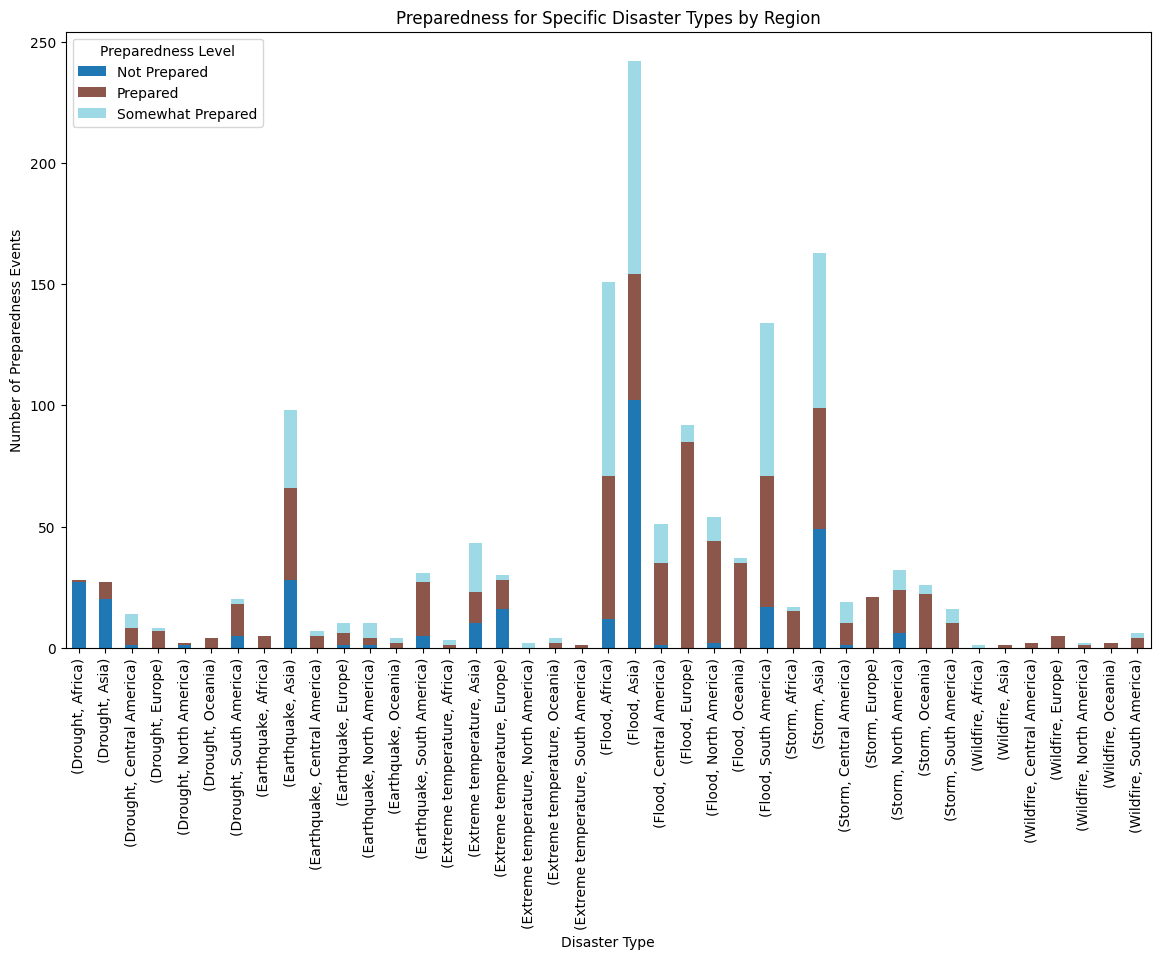

In [ ]:
# Group the data by Region, Disaster Type, and Preparedness Level to calculate the count of preparedness levels
df_region_disaster = df.groupby(['Region', 'Disaster Type', 'Preparedness_Level']).size().reset_index(name='Count')

# Pivot the data to get preparedness level counts for each region by disaster type
df_region_disaster_pivot = df_region_disaster.pivot_table(index=['Disaster Type', 'Region'], columns='Preparedness_Level', values='Count', aggfunc='sum').reset_index()

# Plotting the stacked bar plot with different colors for each region
df_region_disaster_pivot.set_index(['Disaster Type', 'Region'], inplace=True)
df_region_disaster_pivot.plot(kind='bar', stacked=True, figsize=(14, 8), cmap='tab20')

# Adding titles and labels
plt.title('Preparedness for Specific Disaster Types by Region')
plt.xlabel('Disaster Type')
plt.ylabel('Number of Preparedness Events')
plt.legend(title='Preparedness Level', loc='upper left')

# Save the plot
plt.savefig("preparedness_by_disaster_type_and_region.png", dpi=300)

# Show the plot
plt.show()

**Interpretation & Connection to Research Question:**

This analysis is directly connected to the research question by evaluating how different regions are prepared for specific **natural disasters** and their **human rights impact**. The comparison of preparedness across regions highlights which areas are more focused on specific disaster types (such as **earthquakes in Asia** or **floods in Africa**) and whether governments are adequately addressing the risks of certain disasters. For example, while **North America** and **Europe** show strong preparedness for **earthquakes** and **extreme temperatures**, **Asia** and **Africa** face significant challenges in managing disasters like **droughts**, **floods**, and **storms**.

This analysis provides insight into whether governments are making sufficient efforts to improve preparedness for high-risk disaster types in their regions. It helps answer the question of whether certain regions are potentially overlooking specific disaster types, which could lead to inadequate protection of **human rights** during crises, particularly in the most vulnerable regions.

##**Trend Analysis by Region: Preparedness Over Time**

No data available for nan. Skipping plot.


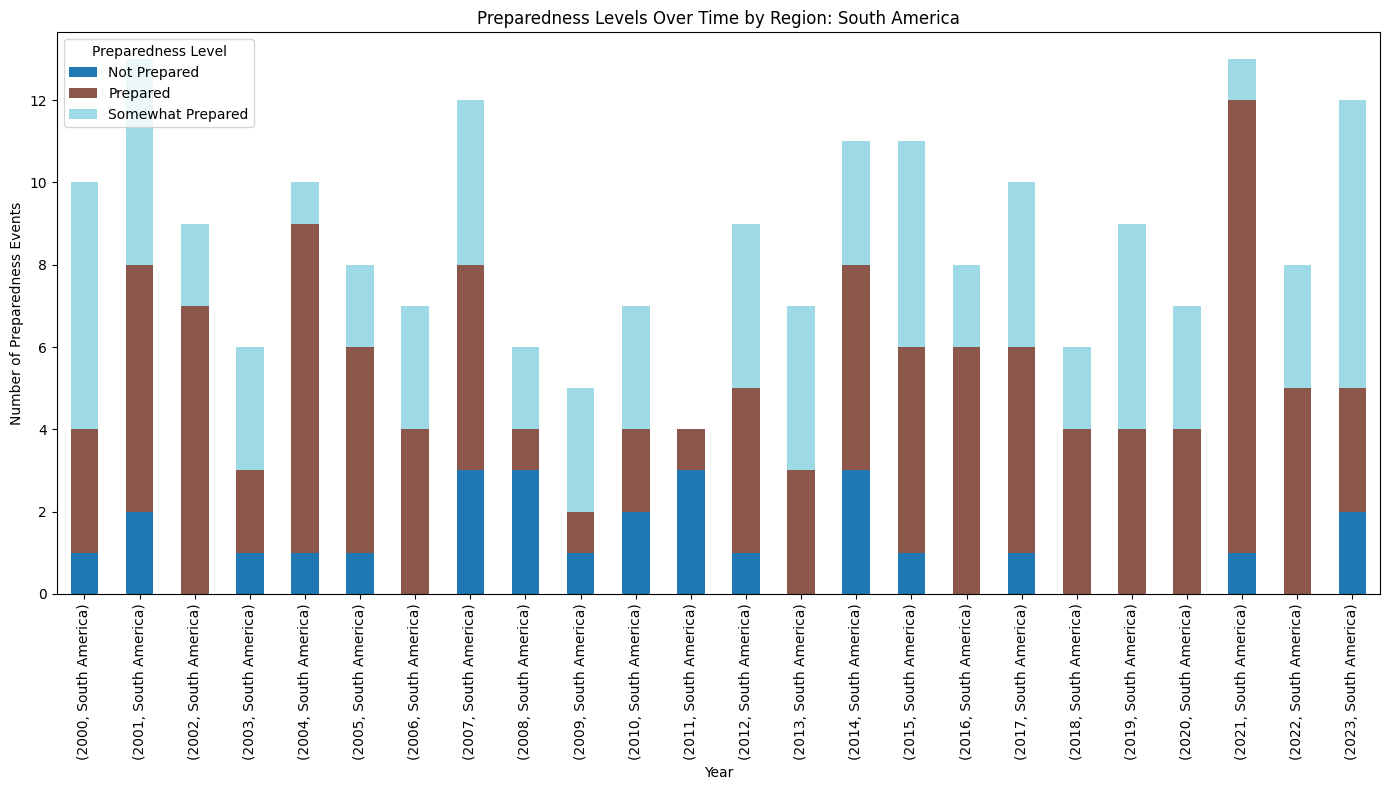

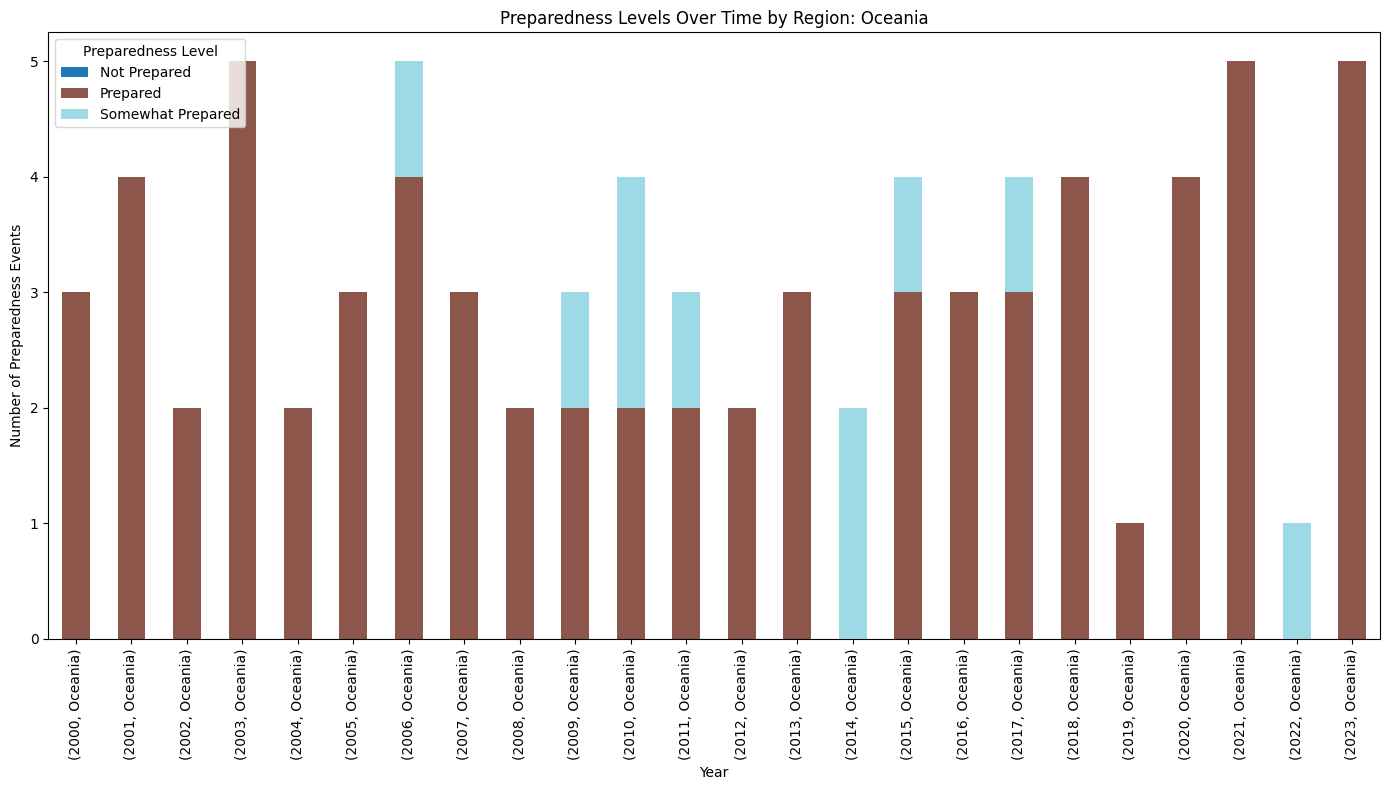

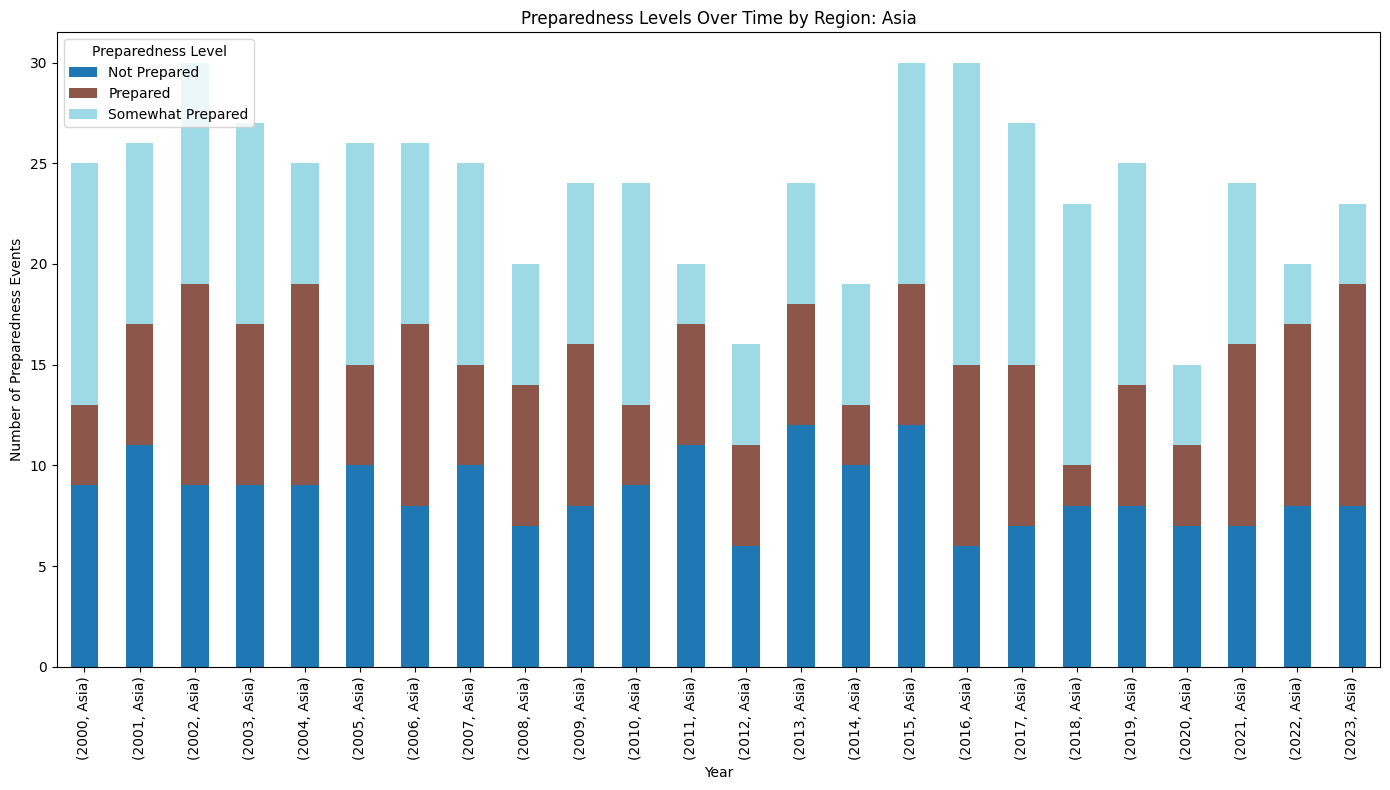

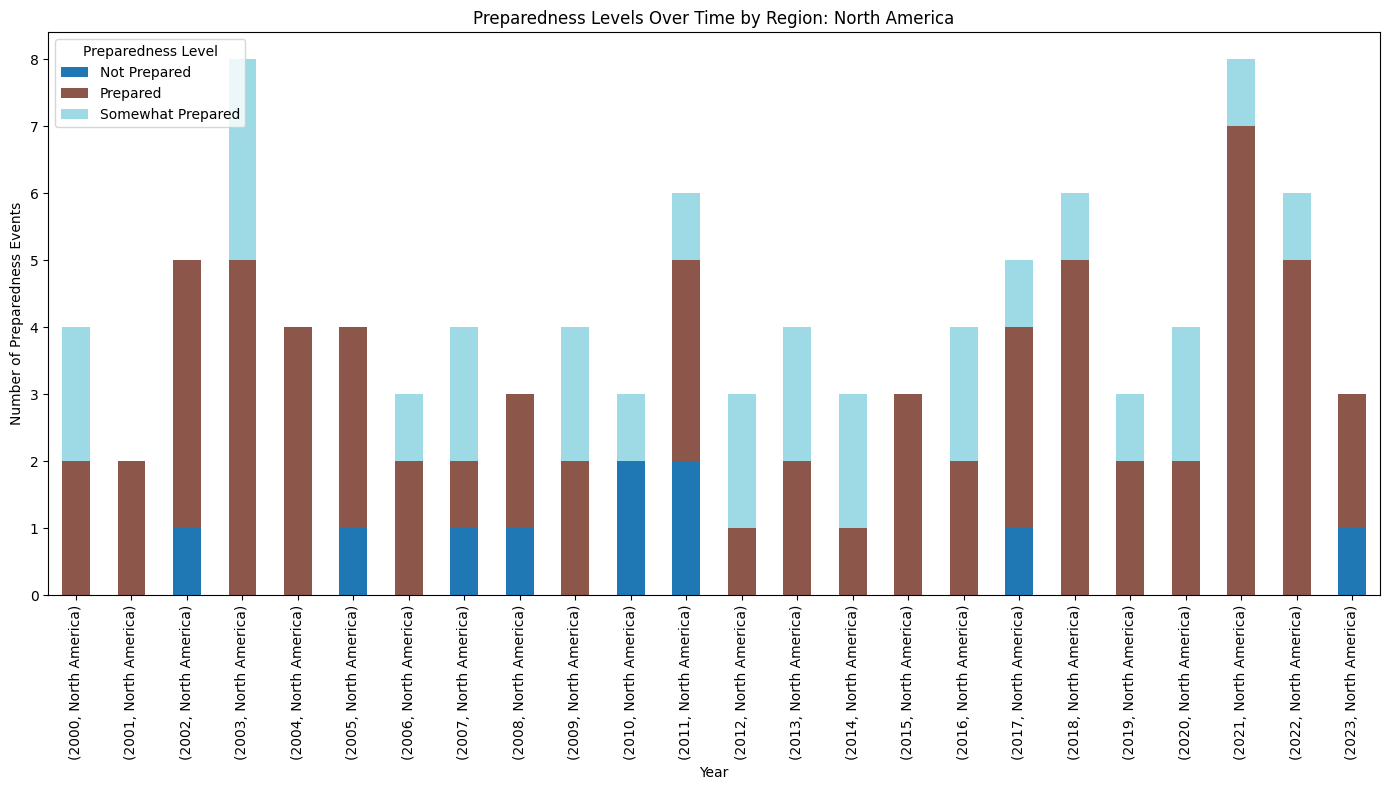

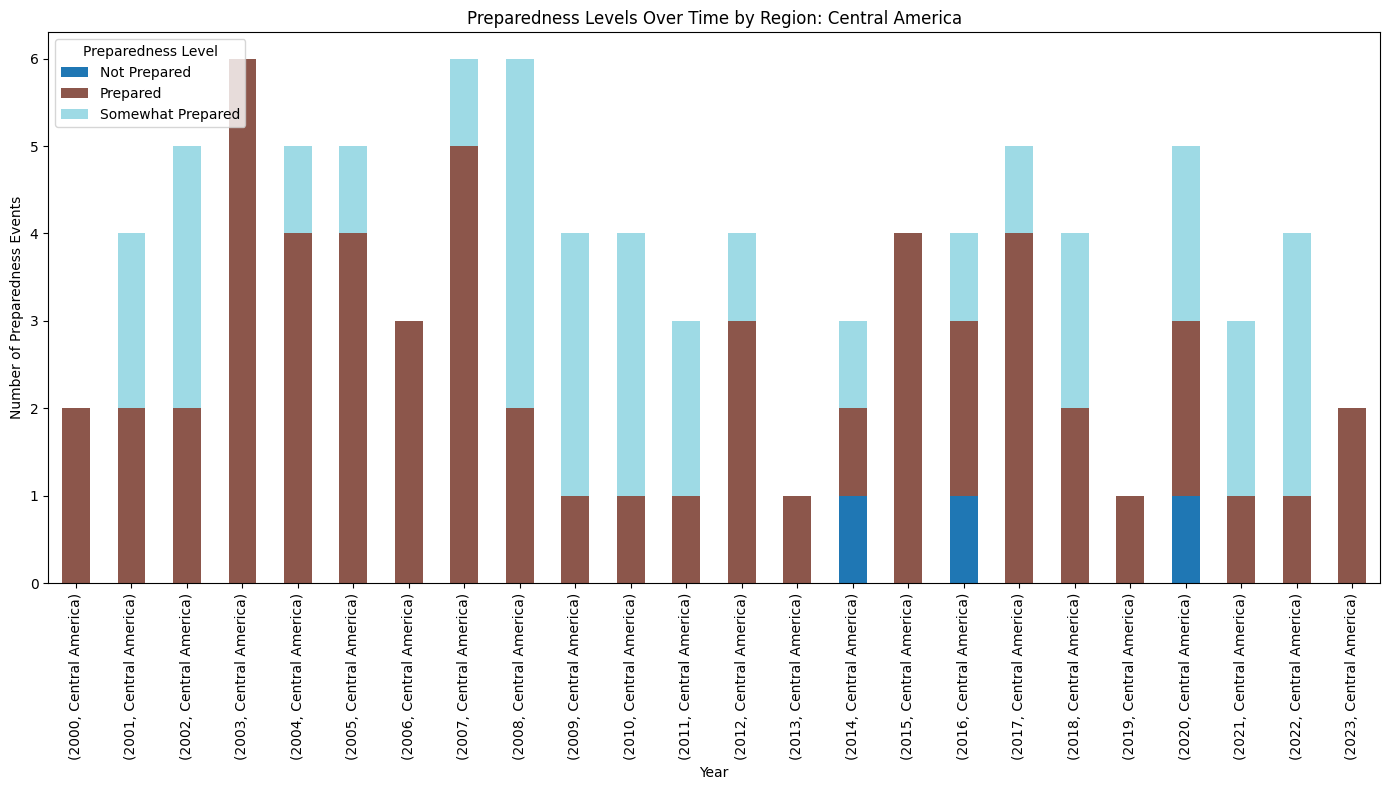

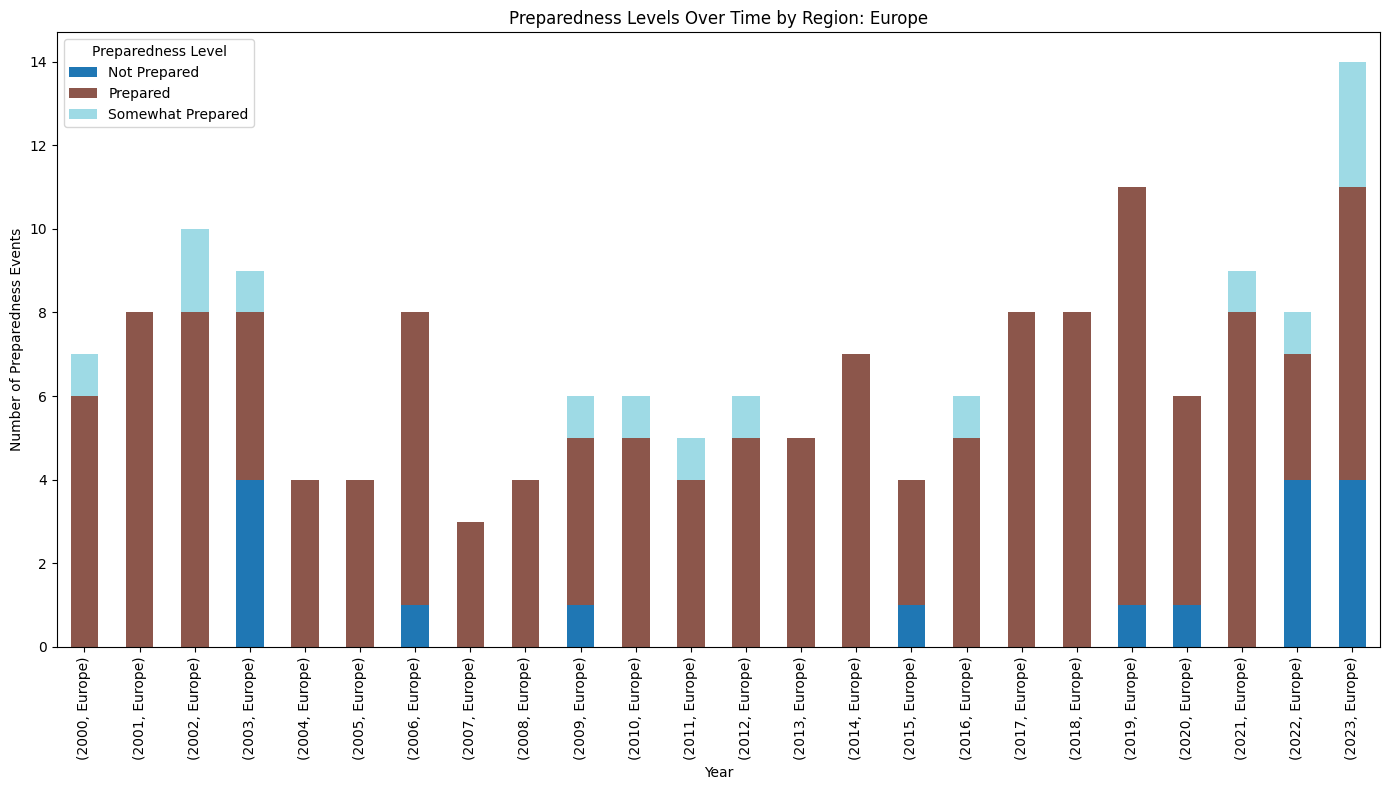

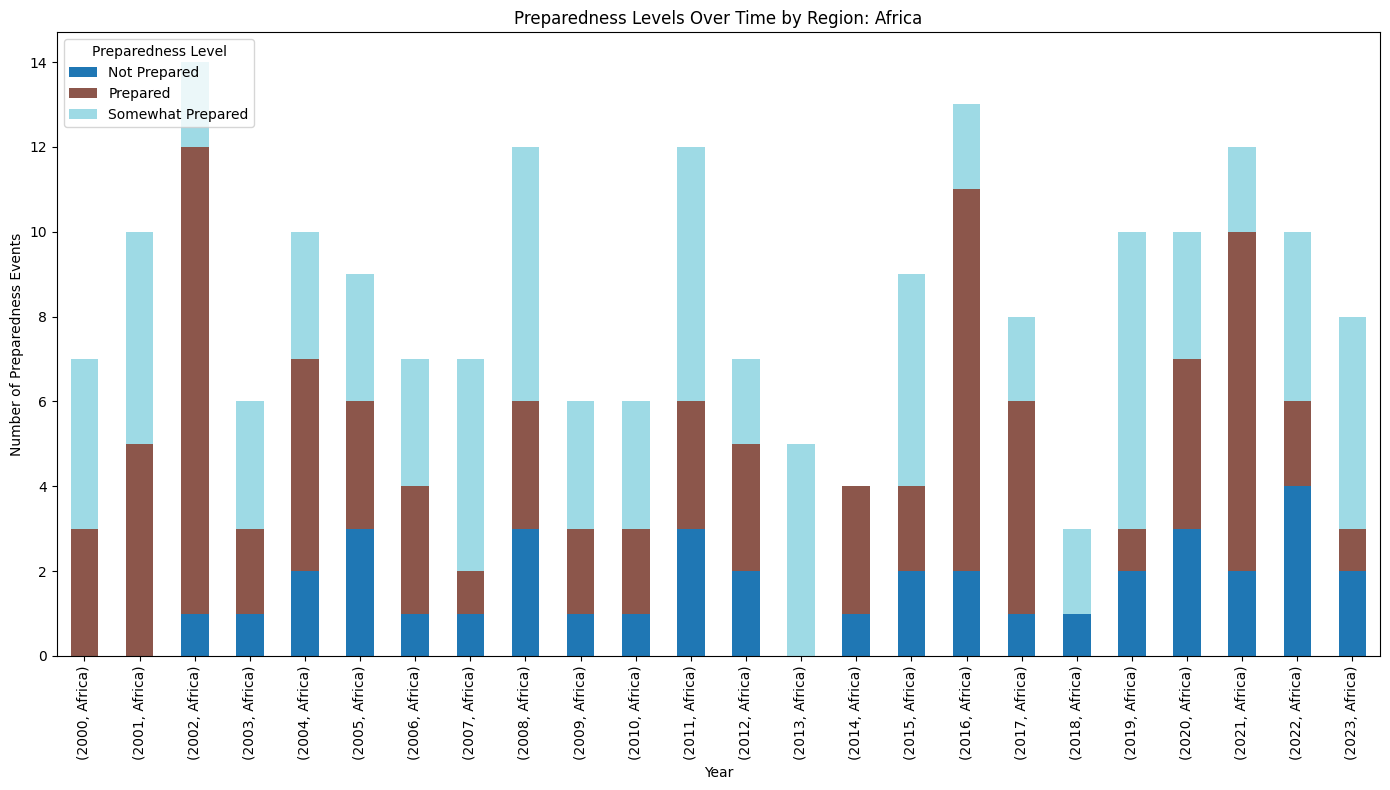

In [ ]:
# Group the data by Region, Year, and Preparedness Level to calculate the count of preparedness levels over time
df_region_year = df.groupby(['Region', 'Year', 'Preparedness_Level']).size().reset_index(name='Count')

# Pivot the data to prepare it for stacked bar plot
df_region_year_pivot = df_region_year.pivot_table(index=['Year', 'Region'], columns='Preparedness_Level', values='Count', aggfunc='sum').reset_index()

# List of regions to plot separately
regions = df['Region'].unique()

# Loop through each region and plot individually
for region in regions:
    region_data = df_region_year_pivot[df_region_year_pivot['Region'] == region]

    # Check if the region data is empty
    if region_data.empty:
        print(f"No data available for {region}. Skipping plot.")
        continue

    # Plot the stacked bar plot by region
    region_data.set_index(['Year', 'Region'], inplace=True)
    region_data.plot(kind='bar', stacked=True, figsize=(14, 8), cmap='tab20')

    # Adding titles and labels
    plt.title(f'Preparedness Levels Over Time by Region: {region}')
    plt.xlabel('Year')
    plt.ylabel('Number of Preparedness Events')
    plt.legend(title='Preparedness Level', loc='upper left')

    # Save the plot
    plt.tight_layout()
    plt.savefig(f"Disaster_Preparedness_{region}.png", bbox_inches='tight')

    # Show the plot
    plt.show()

**Interpretation of Results:**

**South America:**
This region has an overal shift towards being mostly **prepared** and **somewhat prepared** over time (particularly after 2015). There is a consistent effort in improving preparedness levels, although the regions still has some events categorized as **not prepared**.

**Oceania:**
This region has most events categorized as **prepared**, indicating that the region is relatively well-prepared for disasters, although some events still fall under **somewhat prepared**.

**Asia:**
This regions demonstrates a somewhat equal amount of **prepared**, **somewhat prepared**, and **not prepared** across the years. Showing that over the years they have not made significant progress in their preparedness measures.

**North America:**
This region shows a consistent level of preparedness although some events are classed as **not prepared** during certain years.

**Central America:**
This region has most events categorized as **prepared**, indicating that the region is relatively well-prepared for disasters, although some events still fall under **not prepared** in certain years.

**Europe:**
This regions has high preparedness levels. However, there is an increasing trend in the **not prepared** category in recent years, reflecting a potential shift in preparedness measures.

**Africa:**
This regions displays a diverse pattern in events categorized under **prepared**, **somewhat prepared**, and **not prepared**, indicating innefeciveness in preparedness measures.

**Connection to Research Question:**

This analysis directly connects to the research question by examining the effectiveness of governmental preparedness for natural disasters across different regions and the corresponding human rights impacts. By comparing how various regions are preparing for different disaster types over time, this analysis sheds light on whether certain regions, like Asia and Africa, which face more frequent and varied disaster types, are focusing their efforts adequately to address specific challenges, potentially overlooking others. Furthermore, it offers insights into whether improvements in preparedness strategies over time contribute to a reduction in risks to human rights, particularly in Africa, Central America, and South America. The analysis also provides valuable evidence on whether disaster preparedness is evolving in response to emerging risks and climate change, contributing to the broader understanding of state responses to disasters and human rights protections.

## Final Summary: Methods, Findings, and Alignment with Research Question

### Research Question Recap:
> **How effectively do governments protect fundamental human rights in climate disaster-prone regions, and how can data science models assess and improve state preparedness?**

This notebook used a range of descriptive, comparative, and geospatial methods to address this question in detail. Below is a summary of all major steps and findings.

---

### 1. Dataset Preparation and Feature Engineering

- **Merged multi-source data** from EM-DAT (disasters), World Governance Indicators, and derived severity metrics.
- Created new features such as:
  - `Preparedness_Level`: Categorical measure of how prepared a country was in response to disasters.
  - `Preparedness_Score`: Numerical scale to support modeling and visualization.
  - Region codes and subregions for spatial analysis.
- Cleaned and filtered data across **2000–2023** to ensure consistency and temporal comparability.

This step ensured the data was **structured, reliable, and analytically useful** for the research question.

---

### 2. Preparedness Classification

- Countries were categorized into:
  - **Not Prepared** (score < 0.33)
  - **Somewhat Prepared** (0.33–0.67)
  - **Prepared** (> 0.67)
- This classification was based on:
  - Governance effectiveness scores
  - Presence of disaster declarations, international aid requests, and emergency responses

This allowed for a **systematic comparison** across countries and years.

**Finding**: A large share of countries fell into the *Somewhat Prepared* category, indicating partial institutional readiness but inconsistent capacity.

---

### 3. Severity and Rights Impact Indicators

- Constructed severity indicators including:
  - Total deaths, injuries, homelessness, and affected populations
- Interpreted these as **proxy indicators for fundamental rights**:
  - Right to life, health, housing, aid, and protection

This links disaster outcomes directly to **human rights consequences**, supporting the first part of the research question.

**Finding**: Countries with lower preparedness scores consistently had higher severity impacts.

---

### 4. Regional and Temporal Comparisons

- Visualized **preparedness levels by region and subregion**
- Compared **Global North vs Global South**
- Analyzed **year-over-year patterns** in preparedness distribution

**Finding**: Sub-Saharan Africa and South Asia showed higher proportions of unprepared countries, while high-income regions remained consistently prepared.

These insights support **geographically targeted policy recommendations**.

---

### 5. Clustering Countries by Preparedness Profile

- Applied unsupervised clustering (KMeans) using governance and disaster severity features
- Identified country clusters such as:
  - "Consistently Prepared but High Severity"
  - "Low Governance & High Risk"
  - "Moderate Governance & Variable Impact"

**Finding**: Some well-governed countries still faced high rights risks due to exposure, suggesting **governance alone is not sufficient**.

This nuanced classification provides **data-driven groupings for future policy benchmarking.**

---

### 6. Threshold Sensitivity Analysis

- Tested stricter and looser thresholds for what constitutes “Prepared”
- Analyzed how reclassification affected global preparedness maps and regional breakdowns

**Finding**: Preparedness is highly sensitive to where thresholds are set, reinforcing the need for **transparent, context-aware scoring.**

This supports the second part of the research question — **how models can assess preparedness and its limitations.**

---

### Conclusion: Answering the Research Question

> **"How effectively do governments protect human rights in disaster-prone regions?"**

- Countries with stronger governance tend to protect rights more effectively, but not always.
- Preparedness is **multidimensional** — involving governance, institutional response, and structural vulnerabilities.
- **Severity outcomes** are tied to clear human rights implications (life, shelter, aid).

> **"...and how can data science models assess and improve state preparedness?"**

- Through classification, scoring, regional comparison, and cluster modeling, this notebook shows that **data science can track preparedness over time and across regions**.
- It provides a practical framework for **benchmarking and evaluating** government responses in a human rights context.

---